# Didactic Exploration of Multi-Task vs. Single-Task Learning on CIFAR-10

## 1. Introduction

In deep learning, we often train models to perform a single, specific task – this is **Single-Task Learning (STL)**. However, many real-world problems benefit from learning multiple related tasks simultaneously. This approach, known as **Multi-Task Learning (MTL)**, aims to improve a model's generalization capabilities and learning efficiency by leveraging shared knowledge across tasks. The underlying hypothesis is that learning related tasks together can act as a form of **inductive transfer** or regularization, leading to more robust representations.

This notebook provides a hands-on, didactic comparison between STL and different MTL strategies. We will use the **CIFAR-10** dataset as our foundation and build models based on the classic **AlexNet** architecture. Our goal is not necessarily to achieve state-of-the-art results, but rather to understand the *mechanisms* and *behaviors* of these learning paradigms.

### 1.1. Chosen Tasks

We define two distinct tasks using the CIFAR-10 dataset:

1.  **Task 1 (T1): Multi-class Object Classification**: The standard CIFAR-10 challenge – classifying an image into one of its 10 categories (e.g., airplane, dog, cat). This is our primary, 'semantic' task.
2.  **Task 2 (T2): Rotation Classification**: A custom task – determining if an input image has been rotated by 0°, 90°, 180°, or 270°. This task focuses more on orientation and low-level features.

We *intentionally* chose these tasks because they are uncorrelated. Will learning about image orientation help in classifying objects, or will it interfere?

### 1.2. Learning Approaches

We will implement and compare three distinct learning approaches:

1.  **Single-Task Learning (STL)**: Our baseline. We train two *completely independent* AlexNet models, one for each task.
2.  **Hard Parameter Sharing MTL**:  We use *one* AlexNet model with a shared backbone and two *separate* classification heads. This forces tasks to share the same underlying representation.
3.  **Soft Parameter Sharing MTL (Cross-Stitch Networks)**: A more flexible approach. We use *two* AlexNet models but insert "Cross-Stitch" units between certain layers. These units *learn* how to linearly combine features from both networks, allowing for an adaptive, 'soft' sharing of information.

### 1.3. Learning Objectives

By working through this notebook, we will:

* Understand the core concepts of MTL and STL.
* Learn the difference between Hard and Soft parameter sharing.

In [1]:
# ===================================================================
# Setup: Import Libraries and Configure the Environment
# ===================================================================
# Here, we import all necessary libraries and configure our setup,
# including setting up PyTorch to use a GPU if available and ensuring
# reproducibility through random seeds.
# ===================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # For interactive progress bars
import random
from PIL import Image


# -------------------------------------------
# Configuration and Reproducibility
# -------------------------------------------

# Set a random seed for PyTorch, NumPy, and Python's random module.
# This helps in making our experiments reproducible. While deep learning
# training can have inherent randomness (especially on GPUs), setting
# seeds makes it *more* likely to get similar results across runs.
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # These settings can help reproducibility but might impact performance.
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

# -------------------------------------------
# Device Configuration (GPU vs. CPU)
# -------------------------------------------

# We check if a CUDA-enabled GPU is available. If so, we set our 'device'
# to 'cuda'; otherwise, we use the 'cpu'. Training deep learning models
# is significantly faster on GPUs. The .to(device) method will be used
# later to move our models and data to the chosen device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------------------
# Hyperparameters and Constants
# -------------------------------------------

# Define key hyperparameters for our training process.
BATCH_SIZE = 128   # How many samples per batch to load.
NUM_EPOCHS = 100   # Number of complete passes through the training dataset.
LEARNING_RATE = 1e-3 # Controls how much we adjust model weights during training.
NUM_CLASSES_T1 = 10 # CIFAR-10 has 10 classes (Task 1).
NUM_CLASSES_T2 = 4  # Rotation task has 4 classes (0, 90, 180, 270 degrees).



Using device: cuda


## 2. Data Preparation: CIFAR-10 Dataset

We need to load the CIFAR-10 dataset and prepare it for our two distinct tasks. This involves creating a custom PyTorch `Dataset` that can serve data for both tasks simultaneously.

### 2.1. MultiTaskCIFAR10


In [2]:
class MultiTaskCIFAR10(torchvision.datasets.CIFAR10):
    """
    CIFAR-10 expanded for two tasks:
      - Task 1: classify into 10 CIFAR-10 object classes
      - Task 2: classify rotation into 4 angles (0°, 90°, 180°, 270°)

    Each original image is repeated 4 times, once per rotation angle.
    """

    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download,
                         transform=None, target_transform=None)
        self.transform = transform
        # Define the rotation angles
        self.angles = [0, 90, 180, 270]
        # Expanded length = 4 × number of original images
        # Tells PyTorch how many samples the new dataset has (4× more than CIFAR-10).
        self.expanded_len = len(self.data) * len(self.angles)

    def __len__(self):
        # Return the expanded dataset size
        return self.expanded_len

    def __getitem__(self, idx):
        # Picks one of the 50,000 original images.
        angle_idx = idx % 4
        # Picks one of the four rotations.
        orig_idx  = idx // 4

        # Load the original image as a PIL.Image
        img = Image.fromarray(self.data[orig_idx])

        # Get the original CIFAR-10 class label (0–9)
        class_label = self.targets[orig_idx]

        # Rotate the image without changing its size (32×32)
        angle = self.angles[angle_idx]
        img = img.rotate(angle, expand=False)

        # Apply any final transforms (ToTensor, Normalize, etc.)
        if self.transform is not None:
            img = self.transform(img)

        # Rotation label is simply angle_idx (0..3)
        rotation_label = angle_idx

        # Return (image, class_label, rotation_label)
        return img, class_label, rotation_label

**Note**: `ToTensor()` converts a PIL image or NumPy array into a float torch.Tensor with channels-firs`
 ordering and scales pixel values to [0, 1], making them compatible with PyTorch models and subsequent transforms.

In [3]:
# -------------------------------------------
# Create Dataset Instances
# -------------------------------------------
# We create instances of our custom dataset for both training and validation.
train_dataset = MultiTaskCIFAR10(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MultiTaskCIFAR10(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of tes samples: {len(test_dataset)}")

# -------------------------------------------
# Create DataLoaders
# -------------------------------------------
# DataLoaders are PyTorch utilities that provide an iterable over a dataset.
# They handle batching, shuffling, and can use multiple worker processes
# to load data in parallel, which is crucial for efficient GPU utilization.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffling the data is important for training to prevent model bias and improve generalization.
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle the validation/test set.
)

Number of training samples: 200000
Number of tes samples: 40000


### 2.2 Validation Set

In [4]:
# 90% for training, 10% for validation
val_size   = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split with a fixed seed for reproducibility
train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

### 2.3 Visualize a Sample Batch


Visualize a sample batch...


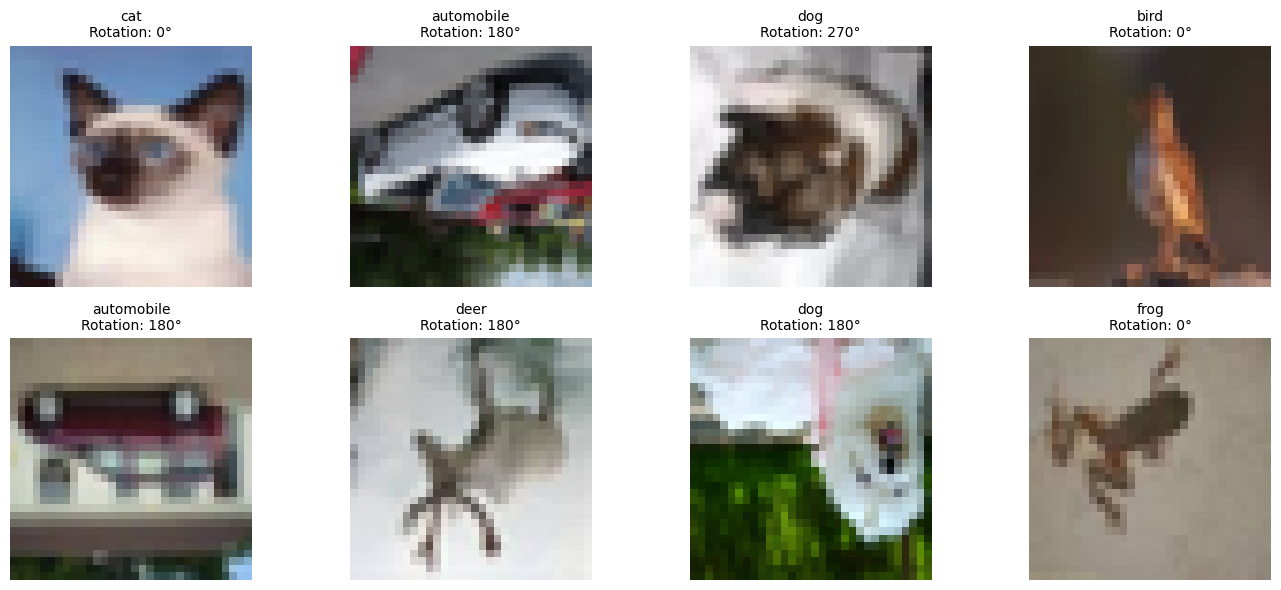

In [5]:
# -------------------------------------------
# Visualize a Sample Batch
# -------------------------------------------
# We visualize a few samples to ensure
# the data loading and transformations are working as expected.

def imshow(img):
    """Helper function to display an image."""
    npimg = img.numpy() # Covert the image to Numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from [C, H, W] to [H, W, C]
    plt.axis('off')

print("\nVisualize a sample batch...")

# Get one batch of training images.
dataiter = iter(train_loader)
images, labels_t1, labels_t2 = next(dataiter)

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Task 2 labesl
rotation_labels = ['0°', '90°', '180°', '270°']

# Plot each image in a 2x4 grid with corresponding labels
# We will show just 8 samples
plt.figure(figsize=(14, 6))
for idx in range(len(images[:8])):
    plt.subplot(2, 4, idx+1)
    imshow(images[idx])
    title = f"{class_names[labels_t1[idx]]}\nRotation: {rotation_labels[labels_t2[idx]]}"
    plt.title(title, fontsize=10)
plt.tight_layout()
plt.show()

## 3. Architectures
To define the architectures we will use, which are based on **AlexNet**, we need:
1.  A base `AlexNet` class.
2.  A `HardMTL` class implementing hard parameter sharing.
3.  A `CrossStitchLayer` and `CrossStitchNetwork` for soft sharing.
4.  A `SingleTask` wrapper for STL.


### 3.1. Base AlexNet

In [6]:
class AlexNet(nn.Module):
    """
    Implementation of the AlexNet architecture, adapted for CIFAR-10.
    """
    def __init__(self, num_outputs=10):
        """
        Initializes the AlexNet model.

        Args:
            num_outputs (int): The number of output neurons in the final layer.
                               This will depend on the task (10 for T1, 4 for T2).
        """
        super(AlexNet, self).__init__() # Always call the parent constructor.

        # --- Feature Extractor (Convolutional Layers) ---
        # This part extracts features from the input image.
        self.features = nn.Sequential(
            # Layer 1: Conv -> ReLU -> MaxPool
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # CIFAR-10 is small (32x32), so we adapt AlexNet.
            nn.ReLU(inplace=True), # ReLU (Rectified Linear Unit) is a common activation function. 'inplace=True' saves memory.
            nn.MaxPool2d(kernel_size=2, stride=2), # Max-pooling reduces spatial dimensions, providing some translation invariance.

            # Layer 2: Conv -> ReLU -> MaxPool
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 3: Conv -> ReLU
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 4: Conv -> ReLU
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 5: Conv -> ReLU -> MaxPool
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # --- Classifier (Fully-Connected Layers) ---
        # This part takes the extracted features and performs classification.
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), # Dropout is a regularization technique to prevent overfitting. It randomly sets some activations to 0.
            nn.Linear(256 * 4 * 4, 1024), # Linear (fully-connected) layer. Input size = channels * height * width from avgpool.
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, num_outputs), # The final output layer, size depends on the task.
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor (batch of images).

        Returns:
            torch.Tensor: The output tensor (logits for each class).
        """
        # Pass through feature extractor.
        x = self.features(x)
        # Flatten the output for the classifier.
        # torch.flatten(x, 1) flattens all dimensions except the batch dimension (dim 0).
        x = torch.flatten(x, 1)
        # Pass through classifier.
        logits = self.classifier(x)
        return logits

### 3.2. Hard Parameter Sharing MTL (`HardMTL`)

This model has one `features` part (shared) and two `classifier` parts (task-specific).

In [7]:
class HardMTL(nn.Module):
    """
    Implements a Hard Parameter Sharing Multi-Task Learning model
    using AlexNet as the base.
    """
    def __init__(self):
        super(HardMTL, self).__init__()
        # --- Shared Feature Extractor ---
        # We take the feature extractor directly from the base AlexNet.
        # These weights will be updated by gradients from BOTH tasks.
        self.features = AlexNet().features

        # --- Task-Specific Classifiers ---
        # We create two separate classifiers, one for each task.
        # We reuse the structure of the AlexNet classifier but adjust the
        # final output layer size for each task.
        self.classifier_t1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, NUM_CLASSES_T1), # Output for Task 1
        )
        self.classifier_t2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, NUM_CLASSES_T2), # Output for Task 2
        )

    def forward(self, x):
        """
        Defines the forward pass for the Hard MTL model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            tuple: (output_t1, output_t2)
                   - output_t1: Logits for Task 1.
                   - output_t2: Logits for Task 2.
        """
        # Pass through the shared layers.
        x = self.features(x)

        x = torch.flatten(x, 1)

        # Pass through the task-specific heads.
        logits_t1 = self.classifier_t1(x)
        logits_t2 = self.classifier_t2(x)

        return logits_t1, logits_t2

### 3.3. Soft Parameter Sharing (Cross-Stitch Network)
Cross-Stitch Networks are a deep learning architecture for Multi-Task Learning (MTL). Their main idea is to let separate networks, each working on a different task, choose how to share and mix information at different layers. This happens using "cross-stitch" units that learn to linearly combine features from each task's pathway. By figuring out how much information to share or keep separate for each task, these networks aim to improve how well they do on all related tasks at once. They try to use shared features when helpful but also allow each task to learn its own special features. This is especially useful when tasks are connected but might need different kinds of features or focus.

Here we need to modify the **AlexNet** implementation in order to better place cross-stitch layers.

In [8]:
class AlexNet_mod(nn.Module):
    def __init__(self, num_outputs=10):
        super(AlexNet_mod, self).__init__()

        # Convolutional Block 1 (Conv1 -> ReLU -> MaxPool1)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 64, 16, 16
        )
        # Convolutional Block 2 (Conv2 -> ReLU -> MaxPool2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 192, 8, 8
        )
        # Convolutional Block 3 (Conv3 -> ReLU -> Conv4 -> ReLU -> Conv5 -> ReLU -> MaxPool3)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 256, 4, 4
        )

        # Classifier Fully-Connected Block 1
        self.fc_block1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True) # Output: B, 1024
        )
        # Classifier Fully-Connected Block 2
        self.fc_block2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True) # Output: B, 1024
        )
        # Final Output Layer
        self.output_layer = nn.Linear(1024, num_outputs)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = torch.flatten(x, 1)
        x = self.fc_block1(x)
        x = self.fc_block2(x)
        logits = self.output_layer(x)
        return logits

#### 3.3.1. Cross-Stitch Layer

Cross-Stitch layer facilitates adaptive information sharing between parallel network branches, designated as A and B, which typically correspond to distinct tasks. At a given layer $l$ where a cross-stitch unit is implemented, let $x_A^{(l)}$ and $x_B^{(l)}$ denote the input activation tensors (feature maps or vectors) from the respective preceding layers of networks A and B.

The core function of the cross-stitch unit at layer $l$ is to transform these input activations into new combined activations, $\tilde{x}_A^{(l)}$ and $\tilde{x}_B^{(l)}$. These transformed activations subsequently serve as inputs to the next layer within their respective network pathways. This transformation is achieved via a learned linear combination, governed by a $2 \times 2$ matrix of scalar parameters:

$$
\begin{bmatrix} \tilde{x}_A^{(l)} \\ \tilde{x}_B^{(l)} \end{bmatrix} =
\begin{bmatrix} \alpha_{AA}^{(l)} & \alpha_{AB}^{(l)} \\ \alpha_{BA}^{(l)} & \alpha_{BB}^{(l)} \end{bmatrix}
\begin{bmatrix} x_A^{(l)} \\ x_B^{(l)} \end{bmatrix}
$$

In this formulation:
-   The diagonal parameters, $\alpha_{AA}^{(l)}$ and $\alpha_{BB}^{(l)}$ (referred to as $\alpha_S$ or same-task weights), modulate the extent to which each task's original activation is propagated within its own network stream.
-   The off-diagonal parameters, $\alpha_{AB}^{(l)}$ and $\alpha_{BA}^{(l)}$ (referred to as $\alpha_D$ or different-task weights), control the degree of influence or "cross-talk" from one task's activations to the other (i.e., how much task B's features affect task A, and vice-versa).

These $\alpha$ parameters are learned independently for each cross-stitch unit deployed at different layers $l$, enabling the network to develop a layer-specific, adaptive sharing strategy tailored to the inter-dependencies of the tasks at various levels of feature abstraction.

In [9]:
class CrossStitchLayer(nn.Module):
    """
    Implements a Cross-Stitch unit.
    This unit learns a 2x2 matrix (alpha) to linearly combine the
    feature maps from two task-specific networks.
    """
    def __init__(self):
        """
        Initializes the Cross-Stitch layer.
        """
        super(CrossStitchLayer, self).__init__()
        # --- Learnable Alpha Matrix ---
        # nn.Parameter tells PyTorch that this tensor should be considered
        # a model parameter, meaning it should be tracked for gradients
        # and updated during training by the optimizer.
        # We use a 2x2 matrix because we have two tasks.
        # We initialize all values to 0.5
        self.alpha = nn.Parameter(torch.ones(2, 2) * 0.5)

    def forward(self, x1, x2):
        """
        Performs the cross-stitch operation.

        Args:
            x1 (torch.Tensor): Feature map from Task 1's network.
            x2 (torch.Tensor): Feature map from Task 2's network.

        Returns:
            tuple: (out1, out2)
                   - out1: Combined feature map for Task 1.
                   - out2: Combined feature map for Task 2.
        """
        # Stack the inputs along a new dimension.
        # If x1 and x2 are (Batch, Features), x_stacked becomes (Batch, Features, 2).
        x_stacked = torch.stack([x1, x2], dim=-1)

        # Perform the linear combination using the alpha matrix.
        # We multiply the stacked inputs by the alpha matrix.
        # PyTorch handles broadcasting correctly:
        # (Batch, Features, 2) * (2, 2) -> (Batch, Features, 2)
        # This effectively does:
        # out1 = alpha[0,0]*x1 + alpha[0,1]*x2
        # out2 = alpha[1,0]*x1 + alpha[1,1]*x2
        out_stacked = torch.matmul(x_stacked, self.alpha)

        # Separate the combined outputs.
        out1 = out_stacked[..., 0]
        out2 = out_stacked[..., 1]
        return out1, out2

#### 3.3.2. CrossStitchNetwork
The `CrossStitchNetwork` class implements the architecture of a Cross-Stitch Network according to the following schema:

<div align="center">
  <img src="images/AlexNet-Cross-Stitch.PNG" alt="Cross-Stitch Network Architecture" width="600">
</div>

---
Misra, I., Shrivastava, A., Gupta, A., & Hebert, M. (2016). *Cross-stitch Networks for Multi-task Learning*. arXiv:1604.03539. [https://arxiv.org/abs/1604.03539](https://arxiv.org/abs/1604.03539)

In [10]:
class CrossStitchNetwork(nn.Module):
    """
    Implements a Cross-Stitch Network using two modified AlexNet backbones,
    with cross-stitch layers applied after every pooling and FC layer.
    """
    def __init__(self):
        super(CrossStitchNetwork, self).__init__()

        self.task1_net = AlexNet_mod(num_outputs=NUM_CLASSES_T1)
        self.task2_net = AlexNet_mod(num_outputs=NUM_CLASSES_T2)

        # --- Cross-Stitch Layers ---
        self.cs_pool1 = CrossStitchLayer()
        self.cs_pool2 = CrossStitchLayer()
        self.cs_pool3 = CrossStitchLayer()

        self.cs_fc1 = CrossStitchLayer()
        self.cs_fc2 = CrossStitchLayer()


    def forward(self, x):
        """
        Defines the forward pass for the Cross-Stitch Network.
        Args:
            x (torch.Tensor): The input tensor.
        Returns:
            tuple: (out1, out2) - Logits for Task 1 and Task 2.
        """
        # --- Initial Input ---
        # Both networks process the same input initially
        x_t1 = x
        x_t2 = x

        # --- Conv Block 1 (includes Pool1) ---
        x_t1_p1 = self.task1_net.conv_block1(x_t1)
        x_t2_p1 = self.task2_net.conv_block1(x_t2)

        x_t1_p1_cs, x_t2_p1_cs = self.cs_pool1(x_t1_p1, x_t2_p1)

        # --- Conv Block 2 (includes Pool2) ---
        x_t1_p2 = self.task1_net.conv_block2(x_t1_p1_cs)
        x_t2_p2 = self.task2_net.conv_block2(x_t2_p1_cs)

        x_t1_p2_cs, x_t2_p2_cs = self.cs_pool2(x_t1_p2, x_t2_p2)

        # --- Conv Block 3 (includes Pool3) ---
        x_t1_p3 = self.task1_net.conv_block3(x_t1_p2_cs)
        x_t2_p3 = self.task2_net.conv_block3(x_t2_p2_cs)

        x_t1_p3_cs, x_t2_p3_cs = self.cs_pool3(x_t1_p3, x_t2_p3)

        # Flatten for Classifier
        x_t1_flat = torch.flatten(x_t1_p3_cs, 1)
        x_t2_flat = torch.flatten(x_t2_p3_cs, 1)

        # --- FC Block 1 ---
        x_t1_fc1 = self.task1_net.fc_block1(x_t1_flat)
        x_t2_fc1 = self.task2_net.fc_block1(x_t2_flat)

        x_t1_fc1_cs, x_t2_fc1_cs = self.cs_fc1(x_t1_fc1, x_t2_fc1)

        # --- FC Block 2 ---
        x_t1_fc2 = self.task1_net.fc_block2(x_t1_fc1_cs)
        x_t2_fc2 = self.task2_net.fc_block2(x_t2_fc1_cs)

        x_t1_fc2_cs, x_t2_fc2_cs = self.cs_fc2(x_t1_fc2, x_t2_fc2)

        # --- Final Output Layers ---
        logits_t1 = self.task1_net.output_layer(x_t1_fc2_cs)
        logits_t2 = self.task2_net.output_layer(x_t2_fc2_cs)

        return logits_t1, logits_t2


### 3.4. Single-Task Learning (`SingleTask`)

This is simply a wrapper around the base `AlexNet` to fit into our training framework easily.

In [11]:
class SingleTask(nn.Module):
    """
    A simple wrapper for AlexNet to represent a Single-Task Learning model.
    """
    def __init__(self, num_outputs):
        super(SingleTask, self).__init__()
        self.model = AlexNet(num_outputs=num_outputs)

    def forward(self, x):
        return self.model(x)

## 4. Training and Evaluation Utilities

We define functions to handle the training and evaluation loops. This keeps our main code cleaner and avoids repetition. We need separate functions for MTL (handling two outputs and losses) and STL (handling one).

**Key PyTorch Steps in Training:**

1.  `model.train()`: Sets the model to training mode (enables dropout, batch norm updates, etc.).
2.  `optimizer.zero_grad()`: Clears old gradients before calculating new ones.
3.  `outputs = model(inputs)`: Performs the forward pass.
4.  `loss = criterion(outputs, labels)`: Calculates the loss.
5.  `loss.backward()`: Computes gradients of the loss w.r.t. model parameters.
6.  `optimizer.step()`: Updates model parameters using the computed gradients and the chosen optimization algorithm.

**Key PyTorch Steps in Evaluation:**

1.  `model.eval()`: Sets the model to evaluation mode (disables dropout, etc.).
2.  `with torch.no_grad()`: Disables gradient calculation, saving memory and computation, as we don't need gradients during evaluation.


In [12]:
# Define the loss function. CrossEntropyLoss is standard for classification.
# It combines LogSoftmax and NLLLoss in one class.
criterion = nn.CrossEntropyLoss()

def generic_train_epoch_mtl(model, loader, optimizer, criterion, device, epoch_num):
    """
    Trains an MTL model for one epoch.
    """
    model.train() # Set model to training mode
    running_total_loss = 0.0
    running_loss_t1 = 0.0
    running_loss_t2 = 0.0
    running_corrects_t1 = 0
    running_corrects_t2 = 0
    total_samples = 0

    # Use tqdm for a progress bar.
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for inputs, labels_t1, labels_t2 in progress_bar:
        # Move data to the selected device (GPU/CPU)
        inputs, labels_t1, labels_t2 = inputs.to(device), labels_t1.to(device), labels_t2.to(device)

        # --- Forward Pass ---
        optimizer.zero_grad() # Zero the parameter gradients
        outputs_t1, outputs_t2 = model(inputs) # Get model outputs

        # --- Loss Calculation ---
        loss_t1 = criterion(outputs_t1, labels_t1)
        loss_t2 = criterion(outputs_t2, labels_t2)
        # Simple MTL loss: Sum of individual task losses.
        # More advanced methods might weigh these differently.
        total_loss = loss_t1 + loss_t2

        # --- Backward Pass & Optimization ---
        total_loss.backward() # Compute gradients
        optimizer.step() # Update weights

        # --- Statistics ---
        _, preds_t1 = torch.max(outputs_t1, 1) # Get predicted class index (highest logit)
        _, preds_t2 = torch.max(outputs_t2, 1)

        running_total_loss += total_loss.item() * images.size(0)
        running_loss_t1 += loss_t1.item() * inputs.size(0)
        running_loss_t2 += loss_t2.item() * inputs.size(0)

        running_corrects_t1 += torch.sum(preds_t1 == labels_t1.data)
        running_corrects_t2 += torch.sum(preds_t2 == labels_t2.data)

        total_samples += inputs.size(0)

        # Update progress bar
        progress_bar.set_postfix(
            loss=f"{total_loss.item():.4f}",
            loss_t1=f"{loss_t1.item():.4f}", acc_t1=f"{(torch.sum(preds_t1 == labels_t1.data)/inputs.size(0))*100:.2f}%",
            loss_t2=f"{loss_t2.item():.4f}", acc_t2=f"{(torch.sum(preds_t2 == labels_t2.data)/inputs.size(0))*100:.2f}%"
        )

    epoch_total_loss = running_total_loss / total_samples
    epoch_loss_t1 = running_loss_t1 / total_samples
    epoch_acc_t1 = running_corrects_t1.double() / total_samples
    epoch_loss_t2 = running_loss_t2 / total_samples
    epoch_acc_t2 = running_corrects_t2.double() / total_samples

    print(f"Training, Epoch {epoch_num}:\n- Loss: {epoch_total_loss:.4f}\n- T1: Loss: {epoch_loss_t1:.4f} - Acc: {epoch_acc_t1*100:.2f}%\n"
          f"- T2: Loss: {epoch_loss_t2:.4f} - Acc: {epoch_acc_t2*100:.2f}%")

    return epoch_total_loss, epoch_loss_t1, epoch_acc_t1.item(), epoch_loss_t2, epoch_acc_t2.item()


def generic_evaluate_epoch_mtl(model, loader, criterion, device, epoch_num, phase="Validation"):
    """
    Evaluates an MTL model for one epoch.
    """
    model.eval() # Set model to evaluation mode
    running_total_loss = 0.0
    running_loss_t1 = 0.0
    running_loss_t2 = 0.0
    running_corrects_t1 = 0
    running_corrects_t2 = 0
    total_samples = 0

    progress_bar = tqdm(loader, desc=f"{phase}", leave=False)

    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels_t1, labels_t2 in progress_bar:
            inputs, labels_t1, labels_t2 = inputs.to(device), labels_t1.to(device), labels_t2.to(device)

            outputs_t1, outputs_t2 = model(inputs)
            loss_t1 = criterion(outputs_t1, labels_t1)
            loss_t2 = criterion(outputs_t2, labels_t2)

            total_loss = loss_t1 + loss_t2

            _, preds_t1 = torch.max(outputs_t1, 1)
            _, preds_t2 = torch.max(outputs_t2, 1)

            running_total_loss += total_loss.item() * images.size(0)
            running_loss_t1 += loss_t1.item() * inputs.size(0)
            running_loss_t2 += loss_t2.item() * inputs.size(0)

            running_corrects_t1 += torch.sum(preds_t1 == labels_t1.data)
            running_corrects_t2 += torch.sum(preds_t2 == labels_t2.data)

            total_samples += inputs.size(0)

            progress_bar.set_postfix(
                loss=f"{total_loss.item():.4f}",
                loss_t1=f"{loss_t1.item():.4f}", acc_t1=f"{(torch.sum(preds_t1 == labels_t1.data)/inputs.size(0))*100:.2f}%",
                loss_t2=f"{loss_t2.item():.4f}", acc_t2=f"{(torch.sum(preds_t2 == labels_t2.data)/inputs.size(0))*100:.2f}%"
            )
    epoch_total_loss = running_total_loss / total_samples
    epoch_loss_t1 = running_loss_t1 / total_samples
    epoch_acc_t1 = running_corrects_t1.double() / total_samples
    epoch_loss_t2 = running_loss_t2 / total_samples
    epoch_acc_t2 = running_corrects_t2.double() / total_samples

    print(f"{phase}{f', Epoch {epoch_num}:' if epoch_num else ''}\n- Loss: {epoch_total_loss:.4f}\n- T1: Loss: {epoch_loss_t1:.4f} - Acc: {epoch_acc_t1*100:.2f}%\n"
          f"- T2: Loss: {epoch_loss_t2:.4f} - Acc: {epoch_acc_t2*100:.2f}%")

    return epoch_total_loss, epoch_loss_t1, epoch_acc_t1.item(), epoch_loss_t2, epoch_acc_t2.item()


# --- Functions for STL ---
# These are similar but simpler as they only handle one task.

def generic_train_epoch_stl(model, loader, optimizer, criterion, device, task_id, epoch_num):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(loader, desc=f"Training on {task_id}", leave=False)

    for inputs, labels_t1, labels_t2 in progress_bar:
        labels = labels_t1 if task_id == "task1" else labels_t2
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(torch.sum(preds == labels.data)/inputs.size(0))*100:.4f}%")

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f"Training, Epoch {epoch_num}:\n- Loss: {epoch_loss:.4f} - Acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc.item()


def generic_evaluate_epoch_stl(model, loader, criterion, device, task_id, epoch_num, phase="Validation"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(loader, desc=f"{phase} on {task_id}", leave=False)

    with torch.no_grad():
        for inputs, labels_t1, labels_t2 in progress_bar:
            labels = labels_t1 if task_id == "task1" else labels_t2
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(torch.sum(preds == labels.data)/inputs.size(0))*100:.2f}%")

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f"{phase}{f', Epoch {epoch_num}: ' if epoch_num else ''}\n- Loss: {epoch_loss:.4f} - Acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc.item()

In [13]:
# --- Generic Training Loop ---
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, model_type, save_path, task_id=None, alpha_history_list=None):
    """
    A generic function to train either MTL or STL models.
    """
    best_validation_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    if model_type == 'mtl':
        history = {'train_loss': [], 'val_loss': [], 'train_loss_t1': [], 'train_acc_t1': [], 'val_loss_t1': [], 'val_acc_t1': [],
                   'train_loss_t2': [], 'train_acc_t2': [], 'val_loss_t2': [], 'val_acc_t2': []}

    for epoch in range(1, num_epochs + 1):
        if model_type == 'mtl':
            train_loss, train_loss_t1, train_acc_t1, train_loss_t2, train_acc_t2 = generic_train_epoch_mtl(
                model, train_loader, optimizer, criterion, device, epoch
            )
            val_loss, val_loss_t1, val_acc_t1, val_loss_t2, val_acc_t2 = generic_evaluate_epoch_mtl(
                model, val_loader, criterion, device, epoch
            )

            history['train_loss_t1'].append(train_loss_t1)
            history['train_acc_t1'].append(train_acc_t1)
            history['val_loss_t1'].append(val_loss_t1)
            history['val_acc_t1'].append(val_acc_t1)
            history['train_loss_t2'].append(train_loss_t2)
            history['train_acc_t2'].append(train_acc_t2)
            history['val_loss_t2'].append(val_loss_t2)
            history['val_acc_t2'].append(val_acc_t2)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

            current_validation_loss = val_loss

        else: # STL
            train_loss, train_acc = generic_train_epoch_stl(
                model, train_loader, optimizer, criterion, device, task_id, epoch
            )
            val_loss, val_acc = generic_evaluate_epoch_stl(
                model, val_loader, criterion, device, task_id, epoch
            )

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            current_validation_loss = val_loss

        # Save alpha values if training Cross-Stitch
        if alpha_history_list is not None and isinstance(model, CrossStitchNetwork):
            alpha_history_list[0].append(model.cs_pool1.alpha.data.cpu().numpy().copy())
            alpha_history_list[1].append(model.cs_pool2.alpha.data.cpu().numpy().copy())
            alpha_history_list[2].append(model.cs_pool3.alpha.data.cpu().numpy().copy())

            alpha_history_list[3].append(model.cs_fc1.alpha.data.cpu().numpy().copy())
            alpha_history_list[4].append(model.cs_fc2.alpha.data.cpu().numpy().copy())

        # Save the best model based on validation loss
        if current_validation_loss < best_validation_loss:
            best_validation_loss = current_validation_loss
            torch.save(model.state_dict(), save_path)

    return history

## 4. Training The Models

Now we put everything together and train each of our models: Hard MTL, Cross-Stitch MTL, and the two STL models.

### 4.1. Hard Parameter Sharing MTL Training

We instantiate the `HardMTL` model, move it to the configured device, set up the Adam optimizer, and start the training loop.

In [14]:
print("--- Training Hard Parameter Sharing MTL ---")
model_hard_mtl = HardMTL().to(device)
optimizer_hard_mtl = optim.Adam(model_hard_mtl.parameters(), lr=LEARNING_RATE)

history_hard_mtl = train_model(
    model_hard_mtl, train_loader, test_loader, optimizer_hard_mtl, criterion,
    device, NUM_EPOCHS, 'mtl', 'best_alexnet_hard_mtl_model.pt'
)
print("--- Hard MTL Training Finished ---\n")

--- Training Hard Parameter Sharing MTL ---


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 2.6409
- T1: Loss: 1.6562 - Acc: 38.84%
- T2: Loss: 0.9839 - Acc: 57.68%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1:
- Loss: 2.2286
- T1: Loss: 1.3585 - Acc: 50.32%
- T2: Loss: 0.8659 - Acc: 63.18%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 2.1394
- T1: Loss: 1.3079 - Acc: 52.41%
- T2: Loss: 0.8308 - Acc: 65.55%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2:
- Loss: 1.9557
- T1: Loss: 1.1848 - Acc: 57.60%
- T2: Loss: 0.7675 - Acc: 69.06%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 1.8652
- T1: Loss: 1.1331 - Acc: 59.33%
- T2: Loss: 0.7315 - Acc: 70.29%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3:
- Loss: 1.7661
- T1: Loss: 1.0725 - Acc: 61.88%
- T2: Loss: 0.6907 - Acc: 71.98%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 1.6909
- T1: Loss: 1.0261 - Acc: 63.37%
- T2: Loss: 0.6643 - Acc: 73.37%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4:
- Loss: 1.6667
- T1: Loss: 1.0154 - Acc: 64.64%
- T2: Loss: 0.6486 - Acc: 74.23%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 1.5734
- T1: Loss: 0.9544 - Acc: 66.07%
- T2: Loss: 0.6185 - Acc: 75.40%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5:
- Loss: 1.5543
- T1: Loss: 0.9307 - Acc: 67.23%
- T2: Loss: 0.6212 - Acc: 75.67%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 1.4848
- T1: Loss: 0.8994 - Acc: 68.08%
- T2: Loss: 0.5849 - Acc: 76.86%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6:
- Loss: 1.4541
- T1: Loss: 0.8786 - Acc: 69.06%
- T2: Loss: 0.5733 - Acc: 77.45%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 1.4161
- T1: Loss: 0.8582 - Acc: 69.50%
- T2: Loss: 0.5573 - Acc: 78.05%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7:
- Loss: 1.4001
- T1: Loss: 0.8370 - Acc: 70.70%
- T2: Loss: 0.5609 - Acc: 78.14%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 1.3518
- T1: Loss: 0.8178 - Acc: 70.97%
- T2: Loss: 0.5336 - Acc: 79.11%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8:
- Loss: 1.3873
- T1: Loss: 0.8267 - Acc: 71.02%
- T2: Loss: 0.5584 - Acc: 78.33%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 1.3072
- T1: Loss: 0.7914 - Acc: 71.94%
- T2: Loss: 0.5152 - Acc: 79.85%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9:
- Loss: 1.3419
- T1: Loss: 0.7955 - Acc: 72.20%
- T2: Loss: 0.5444 - Acc: 78.80%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 1.2649
- T1: Loss: 0.7669 - Acc: 72.77%
- T2: Loss: 0.4976 - Acc: 80.61%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10:
- Loss: 1.3112
- T1: Loss: 0.7878 - Acc: 72.60%
- T2: Loss: 0.5215 - Acc: 79.84%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 1.2241
- T1: Loss: 0.7401 - Acc: 73.83%
- T2: Loss: 0.4836 - Acc: 81.11%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11:
- Loss: 1.2962
- T1: Loss: 0.7791 - Acc: 72.83%
- T2: Loss: 0.5151 - Acc: 80.17%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 1.1950
- T1: Loss: 0.7245 - Acc: 74.33%
- T2: Loss: 0.4701 - Acc: 81.69%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12:
- Loss: 1.3438
- T1: Loss: 0.8273 - Acc: 71.19%
- T2: Loss: 0.5145 - Acc: 79.93%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 1.1650
- T1: Loss: 0.7076 - Acc: 75.05%
- T2: Loss: 0.4569 - Acc: 82.33%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13:
- Loss: 1.2922
- T1: Loss: 0.7829 - Acc: 72.69%
- T2: Loss: 0.5074 - Acc: 80.31%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 1.1337
- T1: Loss: 0.6896 - Acc: 75.55%
- T2: Loss: 0.4437 - Acc: 82.89%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14:
- Loss: 1.2861
- T1: Loss: 0.7648 - Acc: 73.51%
- T2: Loss: 0.5193 - Acc: 80.14%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 1.1065
- T1: Loss: 0.6734 - Acc: 76.28%
- T2: Loss: 0.4328 - Acc: 83.27%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15:
- Loss: 1.2724
- T1: Loss: 0.7645 - Acc: 73.78%
- T2: Loss: 0.5062 - Acc: 80.41%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 1.0818
- T1: Loss: 0.6603 - Acc: 76.63%
- T2: Loss: 0.4212 - Acc: 83.78%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16:
- Loss: 1.2219
- T1: Loss: 0.7384 - Acc: 74.32%
- T2: Loss: 0.4817 - Acc: 81.36%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 1.0533
- T1: Loss: 0.6417 - Acc: 77.43%
- T2: Loss: 0.4112 - Acc: 84.16%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17:
- Loss: 1.2149
- T1: Loss: 0.7352 - Acc: 74.65%
- T2: Loss: 0.4780 - Acc: 81.64%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 1.0323
- T1: Loss: 0.6291 - Acc: 77.86%
- T2: Loss: 0.4028 - Acc: 84.51%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18:
- Loss: 1.2127
- T1: Loss: 0.7310 - Acc: 74.89%
- T2: Loss: 0.4801 - Acc: 81.60%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 1.0106
- T1: Loss: 0.6197 - Acc: 78.20%
- T2: Loss: 0.3907 - Acc: 84.99%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19:
- Loss: 1.2218
- T1: Loss: 0.7419 - Acc: 74.81%
- T2: Loss: 0.4780 - Acc: 81.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.9898
- T1: Loss: 0.6058 - Acc: 78.71%
- T2: Loss: 0.3837 - Acc: 85.25%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20:
- Loss: 1.2249
- T1: Loss: 0.7389 - Acc: 74.72%
- T2: Loss: 0.4845 - Acc: 81.56%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.9655
- T1: Loss: 0.5928 - Acc: 79.07%
- T2: Loss: 0.3724 - Acc: 85.77%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21:
- Loss: 1.2300
- T1: Loss: 0.7386 - Acc: 75.00%
- T2: Loss: 0.4899 - Acc: 81.60%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.9457
- T1: Loss: 0.5807 - Acc: 79.60%
- T2: Loss: 0.3648 - Acc: 86.19%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22:
- Loss: 1.1700
- T1: Loss: 0.7056 - Acc: 75.78%
- T2: Loss: 0.4628 - Acc: 82.40%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.9281
- T1: Loss: 0.5708 - Acc: 80.03%
- T2: Loss: 0.3571 - Acc: 86.44%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23:
- Loss: 1.1834
- T1: Loss: 0.7162 - Acc: 75.52%
- T2: Loss: 0.4657 - Acc: 82.29%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.9083
- T1: Loss: 0.5576 - Acc: 80.47%
- T2: Loss: 0.3503 - Acc: 86.66%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24:
- Loss: 1.2165
- T1: Loss: 0.7342 - Acc: 75.06%
- T2: Loss: 0.4806 - Acc: 81.95%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.8891
- T1: Loss: 0.5487 - Acc: 80.75%
- T2: Loss: 0.3401 - Acc: 87.07%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25:
- Loss: 1.2235
- T1: Loss: 0.7433 - Acc: 75.20%
- T2: Loss: 0.4784 - Acc: 82.00%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.8766
- T1: Loss: 0.5413 - Acc: 81.03%
- T2: Loss: 0.3350 - Acc: 87.26%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26:
- Loss: 1.1885
- T1: Loss: 0.7143 - Acc: 75.72%
- T2: Loss: 0.4725 - Acc: 82.19%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.8555
- T1: Loss: 0.5272 - Acc: 81.55%
- T2: Loss: 0.3280 - Acc: 87.60%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27:
- Loss: 1.1869
- T1: Loss: 0.7182 - Acc: 76.01%
- T2: Loss: 0.4670 - Acc: 82.52%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.8426
- T1: Loss: 0.5215 - Acc: 81.73%
- T2: Loss: 0.3207 - Acc: 87.86%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28:
- Loss: 1.2063
- T1: Loss: 0.7295 - Acc: 75.87%
- T2: Loss: 0.4749 - Acc: 82.29%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.8272
- T1: Loss: 0.5121 - Acc: 82.06%
- T2: Loss: 0.3149 - Acc: 88.11%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29:
- Loss: 1.2222
- T1: Loss: 0.7494 - Acc: 75.32%
- T2: Loss: 0.4711 - Acc: 82.26%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.8133
- T1: Loss: 0.5023 - Acc: 82.40%
- T2: Loss: 0.3107 - Acc: 88.24%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30:
- Loss: 1.2087
- T1: Loss: 0.7289 - Acc: 75.66%
- T2: Loss: 0.4780 - Acc: 82.14%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.8016
- T1: Loss: 0.4968 - Acc: 82.63%
- T2: Loss: 0.3044 - Acc: 88.55%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31:
- Loss: 1.2227
- T1: Loss: 0.7478 - Acc: 75.62%
- T2: Loss: 0.4733 - Acc: 82.60%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.8036
- T1: Loss: 0.4978 - Acc: 82.65%
- T2: Loss: 0.3055 - Acc: 88.52%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32:
- Loss: 1.2096
- T1: Loss: 0.7250 - Acc: 75.99%
- T2: Loss: 0.4829 - Acc: 82.16%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.7780
- T1: Loss: 0.4839 - Acc: 83.15%
- T2: Loss: 0.2939 - Acc: 89.00%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33:
- Loss: 1.2164
- T1: Loss: 0.7464 - Acc: 75.38%
- T2: Loss: 0.4680 - Acc: 82.64%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.7689
- T1: Loss: 0.4780 - Acc: 83.33%
- T2: Loss: 0.2907 - Acc: 89.11%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34:
- Loss: 1.1775
- T1: Loss: 0.7160 - Acc: 76.31%
- T2: Loss: 0.4597 - Acc: 83.19%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.7591
- T1: Loss: 0.4732 - Acc: 83.52%
- T2: Loss: 0.2856 - Acc: 89.27%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35:
- Loss: 1.2008
- T1: Loss: 0.7245 - Acc: 75.89%
- T2: Loss: 0.4748 - Acc: 82.54%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.7560
- T1: Loss: 0.4718 - Acc: 83.59%
- T2: Loss: 0.2840 - Acc: 89.34%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36:
- Loss: 1.2023
- T1: Loss: 0.7405 - Acc: 76.20%
- T2: Loss: 0.4603 - Acc: 82.86%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.7383
- T1: Loss: 0.4591 - Acc: 84.04%
- T2: Loss: 0.2790 - Acc: 89.56%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37:
- Loss: 1.2823
- T1: Loss: 0.8012 - Acc: 74.89%
- T2: Loss: 0.4794 - Acc: 82.08%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.7299
- T1: Loss: 0.4551 - Acc: 84.19%
- T2: Loss: 0.2745 - Acc: 89.75%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38:
- Loss: 1.2158
- T1: Loss: 0.7393 - Acc: 76.58%
- T2: Loss: 0.4751 - Acc: 83.03%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.7245
- T1: Loss: 0.4516 - Acc: 84.32%
- T2: Loss: 0.2725 - Acc: 89.82%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39:
- Loss: 1.2423
- T1: Loss: 0.7730 - Acc: 75.45%
- T2: Loss: 0.4673 - Acc: 82.69%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.7169
- T1: Loss: 0.4491 - Acc: 84.47%
- T2: Loss: 0.2676 - Acc: 90.01%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40:
- Loss: 1.2028
- T1: Loss: 0.7263 - Acc: 76.32%
- T2: Loss: 0.4748 - Acc: 82.92%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.7110
- T1: Loss: 0.4438 - Acc: 84.69%
- T2: Loss: 0.2668 - Acc: 90.10%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41:
- Loss: 1.1804
- T1: Loss: 0.7152 - Acc: 76.88%
- T2: Loss: 0.4635 - Acc: 83.20%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.7062
- T1: Loss: 0.4417 - Acc: 84.76%
- T2: Loss: 0.2642 - Acc: 90.22%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42:
- Loss: 1.2070
- T1: Loss: 0.7465 - Acc: 76.51%
- T2: Loss: 0.4589 - Acc: 83.21%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.6934
- T1: Loss: 0.4329 - Acc: 85.11%
- T2: Loss: 0.2603 - Acc: 90.37%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43:
- Loss: 1.2120
- T1: Loss: 0.7346 - Acc: 76.39%
- T2: Loss: 0.4754 - Acc: 82.75%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.6850
- T1: Loss: 0.4316 - Acc: 85.16%
- T2: Loss: 0.2532 - Acc: 90.55%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44:
- Loss: 1.2665
- T1: Loss: 0.7857 - Acc: 75.61%
- T2: Loss: 0.4788 - Acc: 82.88%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.6933
- T1: Loss: 0.4336 - Acc: 85.19%
- T2: Loss: 0.2594 - Acc: 90.41%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45:
- Loss: 1.2338
- T1: Loss: 0.7510 - Acc: 76.44%
- T2: Loss: 0.4810 - Acc: 82.99%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.6858
- T1: Loss: 0.4287 - Acc: 85.23%
- T2: Loss: 0.2568 - Acc: 90.41%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46:
- Loss: 1.2374
- T1: Loss: 0.7594 - Acc: 76.27%
- T2: Loss: 0.4758 - Acc: 83.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.6796
- T1: Loss: 0.4255 - Acc: 85.46%
- T2: Loss: 0.2538 - Acc: 90.64%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47:
- Loss: 1.2761
- T1: Loss: 0.7825 - Acc: 75.47%
- T2: Loss: 0.4914 - Acc: 82.91%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.6658
- T1: Loss: 0.4189 - Acc: 85.63%
- T2: Loss: 0.2467 - Acc: 90.83%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48:
- Loss: 1.2401
- T1: Loss: 0.7532 - Acc: 76.36%
- T2: Loss: 0.4853 - Acc: 82.98%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.6745
- T1: Loss: 0.4225 - Acc: 85.74%
- T2: Loss: 0.2517 - Acc: 90.71%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49:
- Loss: 1.2680
- T1: Loss: 0.7809 - Acc: 74.93%
- T2: Loss: 0.4853 - Acc: 82.32%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.6655
- T1: Loss: 0.4198 - Acc: 85.75%
- T2: Loss: 0.2453 - Acc: 90.99%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50:
- Loss: 1.2814
- T1: Loss: 0.8062 - Acc: 75.20%
- T2: Loss: 0.4734 - Acc: 82.82%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 51:
- Loss: 0.6538
- T1: Loss: 0.4115 - Acc: 86.12%
- T2: Loss: 0.2420 - Acc: 91.11%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 51:
- Loss: 1.2569
- T1: Loss: 0.7738 - Acc: 75.96%
- T2: Loss: 0.4814 - Acc: 82.85%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 52:
- Loss: 0.6543
- T1: Loss: 0.4104 - Acc: 86.01%
- T2: Loss: 0.2437 - Acc: 91.09%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 52:
- Loss: 1.2486
- T1: Loss: 0.7581 - Acc: 76.61%
- T2: Loss: 0.4886 - Acc: 83.03%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 53:
- Loss: 0.6524
- T1: Loss: 0.4116 - Acc: 86.08%
- T2: Loss: 0.2406 - Acc: 91.17%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 53:
- Loss: 1.2514
- T1: Loss: 0.7756 - Acc: 76.58%
- T2: Loss: 0.4738 - Acc: 83.37%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 54:
- Loss: 0.6425
- T1: Loss: 0.4037 - Acc: 86.32%
- T2: Loss: 0.2385 - Acc: 91.33%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 54:
- Loss: 1.2483
- T1: Loss: 0.7627 - Acc: 77.00%
- T2: Loss: 0.4837 - Acc: 83.14%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 55:
- Loss: 0.6371
- T1: Loss: 0.4015 - Acc: 86.39%
- T2: Loss: 0.2354 - Acc: 91.41%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 55:
- Loss: 1.2328
- T1: Loss: 0.7599 - Acc: 76.67%
- T2: Loss: 0.4711 - Acc: 83.33%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 56:
- Loss: 0.6354
- T1: Loss: 0.3990 - Acc: 86.50%
- T2: Loss: 0.2363 - Acc: 91.35%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 56:
- Loss: 1.2443
- T1: Loss: 0.7761 - Acc: 76.74%
- T2: Loss: 0.4666 - Acc: 83.23%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 57:
- Loss: 0.6314
- T1: Loss: 0.3976 - Acc: 86.51%
- T2: Loss: 0.2336 - Acc: 91.42%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 57:
- Loss: 1.2451
- T1: Loss: 0.7584 - Acc: 76.93%
- T2: Loss: 0.4851 - Acc: 83.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 58:
- Loss: 0.6424
- T1: Loss: 0.4063 - Acc: 86.39%
- T2: Loss: 0.2359 - Acc: 91.48%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 58:
- Loss: 1.2348
- T1: Loss: 0.7685 - Acc: 75.33%
- T2: Loss: 0.4644 - Acc: 82.95%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 59:
- Loss: 0.6483
- T1: Loss: 0.4089 - Acc: 86.25%
- T2: Loss: 0.2392 - Acc: 91.32%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 59:
- Loss: 1.2633
- T1: Loss: 0.7807 - Acc: 76.10%
- T2: Loss: 0.4809 - Acc: 83.04%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 60:
- Loss: 0.6379
- T1: Loss: 0.4033 - Acc: 86.49%
- T2: Loss: 0.2343 - Acc: 91.45%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 60:
- Loss: 1.2825
- T1: Loss: 0.7955 - Acc: 76.78%
- T2: Loss: 0.4849 - Acc: 83.45%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 61:
- Loss: 0.6214
- T1: Loss: 0.3905 - Acc: 86.88%
- T2: Loss: 0.2307 - Acc: 91.63%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 61:
- Loss: 1.2620
- T1: Loss: 0.7871 - Acc: 75.70%
- T2: Loss: 0.4730 - Acc: 82.85%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 62:
- Loss: 0.6215
- T1: Loss: 0.3918 - Acc: 86.90%
- T2: Loss: 0.2295 - Acc: 91.65%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 62:
- Loss: 1.2788
- T1: Loss: 0.7798 - Acc: 76.02%
- T2: Loss: 0.4971 - Acc: 83.34%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 63:
- Loss: 0.8040
- T1: Loss: 0.5005 - Acc: 83.36%
- T2: Loss: 0.3033 - Acc: 88.96%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 63:
- Loss: 1.2666
- T1: Loss: 0.7910 - Acc: 76.11%
- T2: Loss: 0.4739 - Acc: 82.86%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 64:
- Loss: 0.6336
- T1: Loss: 0.4017 - Acc: 86.59%
- T2: Loss: 0.2318 - Acc: 91.58%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 64:
- Loss: 1.2619
- T1: Loss: 0.7803 - Acc: 77.28%
- T2: Loss: 0.4800 - Acc: 83.26%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 65:
- Loss: 0.6435
- T1: Loss: 0.4091 - Acc: 86.43%
- T2: Loss: 0.2343 - Acc: 91.43%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 65:
- Loss: 1.2776
- T1: Loss: 0.7897 - Acc: 75.75%
- T2: Loss: 0.4863 - Acc: 83.01%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 66:
- Loss: 0.6078
- T1: Loss: 0.3845 - Acc: 87.18%
- T2: Loss: 0.2229 - Acc: 91.90%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 66:
- Loss: 1.2810
- T1: Loss: 0.7850 - Acc: 76.42%
- T2: Loss: 0.4945 - Acc: 82.89%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 67:
- Loss: 0.6199
- T1: Loss: 0.3904 - Acc: 87.02%
- T2: Loss: 0.2293 - Acc: 91.70%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 67:
- Loss: 1.3033
- T1: Loss: 0.8060 - Acc: 75.17%
- T2: Loss: 0.4952 - Acc: 82.17%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 68:
- Loss: 0.5997
- T1: Loss: 0.3797 - Acc: 87.33%
- T2: Loss: 0.2197 - Acc: 92.02%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 68:
- Loss: 1.3443
- T1: Loss: 0.8257 - Acc: 75.79%
- T2: Loss: 0.5164 - Acc: 82.64%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 69:
- Loss: 0.6032
- T1: Loss: 0.3810 - Acc: 87.32%
- T2: Loss: 0.2220 - Acc: 91.92%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 69:
- Loss: 1.2696
- T1: Loss: 0.7880 - Acc: 76.51%
- T2: Loss: 0.4802 - Acc: 82.82%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 70:
- Loss: 0.6093
- T1: Loss: 0.3852 - Acc: 87.27%
- T2: Loss: 0.2240 - Acc: 91.90%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 70:
- Loss: 1.3424
- T1: Loss: 0.8192 - Acc: 76.04%
- T2: Loss: 0.5214 - Acc: 82.87%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 71:
- Loss: 0.6040
- T1: Loss: 0.3827 - Acc: 87.30%
- T2: Loss: 0.2211 - Acc: 92.02%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 71:
- Loss: 1.3030
- T1: Loss: 0.8082 - Acc: 75.83%
- T2: Loss: 0.4933 - Acc: 82.62%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 72:
- Loss: 0.6319
- T1: Loss: 0.3972 - Acc: 86.83%
- T2: Loss: 0.2346 - Acc: 91.57%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 72:
- Loss: 1.2780
- T1: Loss: 0.7947 - Acc: 76.99%
- T2: Loss: 0.4816 - Acc: 83.17%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 73:
- Loss: 0.6250
- T1: Loss: 0.3987 - Acc: 86.93%
- T2: Loss: 0.2260 - Acc: 91.78%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 73:
- Loss: 1.2897
- T1: Loss: 0.8127 - Acc: 75.54%
- T2: Loss: 0.4755 - Acc: 82.99%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 74:
- Loss: 0.6000
- T1: Loss: 0.3789 - Acc: 87.59%
- T2: Loss: 0.2207 - Acc: 92.00%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 74:
- Loss: 1.2792
- T1: Loss: 0.7925 - Acc: 76.00%
- T2: Loss: 0.4846 - Acc: 82.97%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 75:
- Loss: 0.6326
- T1: Loss: 0.3998 - Acc: 86.88%
- T2: Loss: 0.2326 - Acc: 91.56%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 75:
- Loss: 1.3355
- T1: Loss: 0.8062 - Acc: 76.47%
- T2: Loss: 0.5274 - Acc: 82.88%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 76:
- Loss: 0.6566
- T1: Loss: 0.4153 - Acc: 86.53%
- T2: Loss: 0.2410 - Acc: 91.33%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 76:
- Loss: 1.3658
- T1: Loss: 0.8484 - Acc: 72.49%
- T2: Loss: 0.5155 - Acc: 81.23%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 77:
- Loss: 0.6113
- T1: Loss: 0.3861 - Acc: 87.40%
- T2: Loss: 0.2250 - Acc: 91.92%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 77:
- Loss: 1.3221
- T1: Loss: 0.8102 - Acc: 76.19%
- T2: Loss: 0.5101 - Acc: 83.06%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 78:
- Loss: 0.5905
- T1: Loss: 0.3748 - Acc: 87.73%
- T2: Loss: 0.2155 - Acc: 92.18%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 78:
- Loss: 1.2941
- T1: Loss: 0.7978 - Acc: 76.69%
- T2: Loss: 0.4943 - Acc: 83.41%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 79:
- Loss: 0.6185
- T1: Loss: 0.3923 - Acc: 87.22%
- T2: Loss: 0.2260 - Acc: 91.87%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 79:
- Loss: 1.2894
- T1: Loss: 0.7818 - Acc: 75.85%
- T2: Loss: 0.5049 - Acc: 82.72%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 80:
- Loss: 0.8964
- T1: Loss: 0.5684 - Acc: 81.54%
- T2: Loss: 0.3277 - Acc: 87.91%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 80:
- Loss: 1.2864
- T1: Loss: 0.7853 - Acc: 75.33%
- T2: Loss: 0.4985 - Acc: 81.97%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 81:
- Loss: 0.6500
- T1: Loss: 0.4125 - Acc: 86.57%
- T2: Loss: 0.2374 - Acc: 91.36%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 81:
- Loss: 1.2820
- T1: Loss: 0.7804 - Acc: 76.34%
- T2: Loss: 0.4993 - Acc: 82.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 82:
- Loss: 0.5944
- T1: Loss: 0.3767 - Acc: 87.76%
- T2: Loss: 0.2175 - Acc: 92.19%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 82:
- Loss: 1.3811
- T1: Loss: 0.8766 - Acc: 72.18%
- T2: Loss: 0.5027 - Acc: 81.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 83:
- Loss: 0.6204
- T1: Loss: 0.3909 - Acc: 87.33%
- T2: Loss: 0.2292 - Acc: 91.81%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 83:
- Loss: 1.3025
- T1: Loss: 0.8035 - Acc: 76.63%
- T2: Loss: 0.4969 - Acc: 83.42%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 84:
- Loss: 0.6346
- T1: Loss: 0.4018 - Acc: 87.06%
- T2: Loss: 0.2327 - Acc: 91.68%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 84:
- Loss: 1.3011
- T1: Loss: 0.8145 - Acc: 76.17%
- T2: Loss: 0.4848 - Acc: 83.17%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 85:
- Loss: 0.6537
- T1: Loss: 0.4148 - Acc: 86.63%
- T2: Loss: 0.2386 - Acc: 91.41%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 85:
- Loss: 1.3659
- T1: Loss: 0.8636 - Acc: 73.71%
- T2: Loss: 0.4998 - Acc: 81.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 86:
- Loss: 0.6713
- T1: Loss: 0.4260 - Acc: 86.35%
- T2: Loss: 0.2450 - Acc: 91.16%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 86:
- Loss: 1.3489
- T1: Loss: 0.8492 - Acc: 76.42%
- T2: Loss: 0.4978 - Acc: 83.39%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 87:
- Loss: 0.6359
- T1: Loss: 0.4038 - Acc: 86.97%
- T2: Loss: 0.2317 - Acc: 91.70%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 87:
- Loss: 1.3199
- T1: Loss: 0.7908 - Acc: 77.21%
- T2: Loss: 0.5270 - Acc: 83.15%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 88:
- Loss: 0.6567
- T1: Loss: 0.4203 - Acc: 86.63%
- T2: Loss: 0.2361 - Acc: 91.49%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 88:
- Loss: 1.3214
- T1: Loss: 0.8263 - Acc: 76.00%
- T2: Loss: 0.4936 - Acc: 82.84%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 89:
- Loss: 0.6123
- T1: Loss: 0.3883 - Acc: 87.45%
- T2: Loss: 0.2237 - Acc: 91.94%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 89:
- Loss: 1.3567
- T1: Loss: 0.8587 - Acc: 76.03%
- T2: Loss: 0.4958 - Acc: 82.71%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 90:
- Loss: 0.6729
- T1: Loss: 0.4239 - Acc: 86.36%
- T2: Loss: 0.2487 - Acc: 91.06%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 90:
- Loss: 1.2652
- T1: Loss: 0.7825 - Acc: 77.52%
- T2: Loss: 0.4806 - Acc: 83.47%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 91:
- Loss: 0.6799
- T1: Loss: 0.4304 - Acc: 86.19%
- T2: Loss: 0.2493 - Acc: 90.96%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 91:
- Loss: 1.2957
- T1: Loss: 0.8027 - Acc: 77.09%
- T2: Loss: 0.4909 - Acc: 83.42%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 92:
- Loss: 0.6866
- T1: Loss: 0.4292 - Acc: 86.33%
- T2: Loss: 0.2572 - Acc: 90.91%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 92:
- Loss: 1.3372
- T1: Loss: 0.8262 - Acc: 75.51%
- T2: Loss: 0.5085 - Acc: 82.30%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 93:
- Loss: 0.6577
- T1: Loss: 0.4181 - Acc: 86.79%
- T2: Loss: 0.2394 - Acc: 91.51%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 93:
- Loss: 1.3671
- T1: Loss: 0.8728 - Acc: 74.47%
- T2: Loss: 0.4923 - Acc: 82.30%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 94:
- Loss: 0.7078
- T1: Loss: 0.4477 - Acc: 85.81%
- T2: Loss: 0.2599 - Acc: 90.65%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 94:
- Loss: 1.3230
- T1: Loss: 0.8452 - Acc: 75.92%
- T2: Loss: 0.4759 - Acc: 83.18%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 95:
- Loss: 0.7351
- T1: Loss: 0.4635 - Acc: 85.31%
- T2: Loss: 0.2715 - Acc: 90.35%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 95:
- Loss: 1.2523
- T1: Loss: 0.7837 - Acc: 76.32%
- T2: Loss: 0.4669 - Acc: 83.03%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 96:
- Loss: 0.8257
- T1: Loss: 0.5234 - Acc: 83.37%
- T2: Loss: 0.3021 - Acc: 89.01%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 96:
- Loss: 1.3541
- T1: Loss: 0.8570 - Acc: 75.04%
- T2: Loss: 0.4953 - Acc: 82.59%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 97:
- Loss: 0.6998
- T1: Loss: 0.4473 - Acc: 85.94%
- T2: Loss: 0.2523 - Acc: 90.88%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 97:
- Loss: 1.2932
- T1: Loss: 0.8008 - Acc: 76.85%
- T2: Loss: 0.4905 - Acc: 83.56%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 98:
- Loss: 0.7721
- T1: Loss: 0.4832 - Acc: 84.74%
- T2: Loss: 0.2886 - Acc: 89.69%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 98:
- Loss: 1.2992
- T1: Loss: 0.8147 - Acc: 76.28%
- T2: Loss: 0.4824 - Acc: 82.89%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 99:
- Loss: 0.7248
- T1: Loss: 0.4671 - Acc: 85.41%
- T2: Loss: 0.2575 - Acc: 90.74%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 99:
- Loss: 1.3530
- T1: Loss: 0.8310 - Acc: 76.52%
- T2: Loss: 0.5198 - Acc: 82.83%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 100:
- Loss: 0.7291
- T1: Loss: 0.4599 - Acc: 85.49%
- T2: Loss: 0.2689 - Acc: 90.38%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 100:
- Loss: 1.3019
- T1: Loss: 0.8019 - Acc: 76.84%
- T2: Loss: 0.4981 - Acc: 83.23%
--- Hard MTL Training Finished ---



### 4.2. Cross-Stitch Network (Soft Sharing) MTL Training

Here, we train the `CrossStitchNetwork`. We also initialize lists to store the `alpha` coefficients from each Cross-Stitch layer during training. This will allow us to visualize how the network learns to share information.

In [15]:
print("--- Training Cross-Stitch Network MTL ---")
model_cs = CrossStitchNetwork().to(device)
optimizer_cs = optim.Adam(model_cs.parameters(), lr=LEARNING_RATE)

# Lists to store alpha values (one list per CS layer)
alphas_cs1_history = []
alphas_cs2_history = []
alphas_cs3_history = []
alphas_cs4_history = []
alphas_cs5_history = []
alpha_history_list_cs = [alphas_cs1_history, alphas_cs2_history, alphas_cs3_history, alphas_cs4_history, alphas_cs5_history]

history_cs = train_model(
    model_cs, train_loader, test_loader, optimizer_cs, criterion,
    device, NUM_EPOCHS, 'mtl', 'best_alexnet_cs_model.pt',
    alpha_history_list=alpha_history_list_cs
)
print("--- Cross-Stitch Training Finished ---\n")

--- Training Cross-Stitch Network MTL ---


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 2.7841
- T1: Loss: 1.7585 - Acc: 35.17%
- T2: Loss: 1.0248 - Acc: 55.25%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1:
- Loss: 2.4116
- T1: Loss: 1.5021 - Acc: 45.01%
- T2: Loss: 0.9053 - Acc: 61.40%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 2.2811
- T1: Loss: 1.4111 - Acc: 48.61%
- T2: Loss: 0.8693 - Acc: 63.64%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2:
- Loss: 2.0721
- T1: Loss: 1.2685 - Acc: 54.04%
- T2: Loss: 0.8005 - Acc: 67.28%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 1.9972
- T1: Loss: 1.2233 - Acc: 55.61%
- T2: Loss: 0.7733 - Acc: 68.24%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3:
- Loss: 1.8064
- T1: Loss: 1.0914 - Acc: 61.05%
- T2: Loss: 0.7123 - Acc: 71.21%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 1.7894
- T1: Loss: 1.0877 - Acc: 60.92%
- T2: Loss: 0.7011 - Acc: 71.56%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4:
- Loss: 1.6627
- T1: Loss: 1.0110 - Acc: 63.99%
- T2: Loss: 0.6494 - Acc: 73.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 1.6361
- T1: Loss: 0.9901 - Acc: 64.48%
- T2: Loss: 0.6456 - Acc: 74.10%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5:
- Loss: 1.5484
- T1: Loss: 0.9372 - Acc: 66.57%
- T2: Loss: 0.6089 - Acc: 75.62%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 1.5235
- T1: Loss: 0.9180 - Acc: 67.18%
- T2: Loss: 0.6050 - Acc: 75.85%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6:
- Loss: 1.4330
- T1: Loss: 0.8528 - Acc: 69.78%
- T2: Loss: 0.5781 - Acc: 76.77%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 1.4346
- T1: Loss: 0.8632 - Acc: 69.15%
- T2: Loss: 0.5709 - Acc: 77.27%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7:
- Loss: 1.3624
- T1: Loss: 0.8112 - Acc: 71.27%
- T2: Loss: 0.5491 - Acc: 78.02%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 1.3575
- T1: Loss: 0.8150 - Acc: 70.97%
- T2: Loss: 0.5421 - Acc: 78.57%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8:
- Loss: 1.3574
- T1: Loss: 0.8130 - Acc: 71.58%
- T2: Loss: 0.5423 - Acc: 78.41%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 1.2886
- T1: Loss: 0.7715 - Acc: 72.41%
- T2: Loss: 0.5167 - Acc: 79.72%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9:
- Loss: 1.2929
- T1: Loss: 0.7750 - Acc: 72.81%
- T2: Loss: 0.5159 - Acc: 79.58%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 1.2269
- T1: Loss: 0.7346 - Acc: 73.84%
- T2: Loss: 0.4918 - Acc: 80.67%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10:
- Loss: 1.2982
- T1: Loss: 0.7886 - Acc: 72.30%
- T2: Loss: 0.5077 - Acc: 80.14%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 1.1714
- T1: Loss: 0.7000 - Acc: 75.07%
- T2: Loss: 0.4711 - Acc: 81.58%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11:
- Loss: 1.2221
- T1: Loss: 0.7319 - Acc: 74.56%
- T2: Loss: 0.4882 - Acc: 81.11%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 1.1133
- T1: Loss: 0.6643 - Acc: 76.22%
- T2: Loss: 0.4486 - Acc: 82.64%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12:
- Loss: 1.2053
- T1: Loss: 0.7201 - Acc: 75.04%
- T2: Loss: 0.4833 - Acc: 81.25%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 1.0717
- T1: Loss: 0.6392 - Acc: 77.15%
- T2: Loss: 0.4322 - Acc: 83.20%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13:
- Loss: 1.2055
- T1: Loss: 0.7261 - Acc: 74.89%
- T2: Loss: 0.4770 - Acc: 81.42%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 1.0293
- T1: Loss: 0.6135 - Acc: 78.06%
- T2: Loss: 0.4156 - Acc: 83.86%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14:
- Loss: 1.1760
- T1: Loss: 0.6959 - Acc: 75.75%
- T2: Loss: 0.4782 - Acc: 81.58%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 0.9861
- T1: Loss: 0.5873 - Acc: 79.00%
- T2: Loss: 0.3984 - Acc: 84.52%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15:
- Loss: 1.1603
- T1: Loss: 0.7026 - Acc: 76.09%
- T2: Loss: 0.4557 - Acc: 82.34%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 0.9463
- T1: Loss: 0.5637 - Acc: 79.91%
- T2: Loss: 0.3823 - Acc: 85.24%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16:
- Loss: 1.1376
- T1: Loss: 0.6819 - Acc: 76.61%
- T2: Loss: 0.4541 - Acc: 82.59%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 0.9072
- T1: Loss: 0.5393 - Acc: 80.70%
- T2: Loss: 0.3677 - Acc: 85.87%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17:
- Loss: 1.1128
- T1: Loss: 0.6664 - Acc: 77.26%
- T2: Loss: 0.4447 - Acc: 82.95%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 0.8789
- T1: Loss: 0.5207 - Acc: 81.38%
- T2: Loss: 0.3580 - Acc: 86.25%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18:
- Loss: 1.1022
- T1: Loss: 0.6610 - Acc: 77.47%
- T2: Loss: 0.4397 - Acc: 83.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 0.8442
- T1: Loss: 0.5011 - Acc: 82.00%
- T2: Loss: 0.3427 - Acc: 86.92%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19:
- Loss: 1.1214
- T1: Loss: 0.6803 - Acc: 77.24%
- T2: Loss: 0.4397 - Acc: 83.23%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.8164
- T1: Loss: 0.4850 - Acc: 82.55%
- T2: Loss: 0.3313 - Acc: 87.31%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20:
- Loss: 1.1351
- T1: Loss: 0.6826 - Acc: 77.41%
- T2: Loss: 0.4504 - Acc: 83.18%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.7875
- T1: Loss: 0.4672 - Acc: 83.19%
- T2: Loss: 0.3200 - Acc: 87.78%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21:
- Loss: 1.0938
- T1: Loss: 0.6588 - Acc: 77.94%
- T2: Loss: 0.4333 - Acc: 83.53%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.7529
- T1: Loss: 0.4454 - Acc: 83.98%
- T2: Loss: 0.3073 - Acc: 88.31%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22:
- Loss: 1.1107
- T1: Loss: 0.6662 - Acc: 78.15%
- T2: Loss: 0.4428 - Acc: 83.62%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.7296
- T1: Loss: 0.4311 - Acc: 84.46%
- T2: Loss: 0.2983 - Acc: 88.55%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23:
- Loss: 1.0882
- T1: Loss: 0.6485 - Acc: 78.42%
- T2: Loss: 0.4382 - Acc: 83.77%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.7032
- T1: Loss: 0.4161 - Acc: 85.05%
- T2: Loss: 0.2869 - Acc: 89.07%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24:
- Loss: 1.1066
- T1: Loss: 0.6664 - Acc: 78.37%
- T2: Loss: 0.4386 - Acc: 83.92%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.6785
- T1: Loss: 0.4011 - Acc: 85.51%
- T2: Loss: 0.2772 - Acc: 89.46%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25:
- Loss: 1.0888
- T1: Loss: 0.6562 - Acc: 78.79%
- T2: Loss: 0.4308 - Acc: 84.11%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.6623
- T1: Loss: 0.3919 - Acc: 85.87%
- T2: Loss: 0.2702 - Acc: 89.73%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26:
- Loss: 1.1000
- T1: Loss: 0.6566 - Acc: 78.45%
- T2: Loss: 0.4416 - Acc: 83.92%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.6363
- T1: Loss: 0.3749 - Acc: 86.48%
- T2: Loss: 0.2612 - Acc: 90.09%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27:
- Loss: 1.0700
- T1: Loss: 0.6404 - Acc: 79.24%
- T2: Loss: 0.4279 - Acc: 84.29%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.6101
- T1: Loss: 0.3610 - Acc: 86.99%
- T2: Loss: 0.2490 - Acc: 90.59%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28:
- Loss: 1.0803
- T1: Loss: 0.6494 - Acc: 79.02%
- T2: Loss: 0.4296 - Acc: 84.08%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.5952
- T1: Loss: 0.3510 - Acc: 87.33%
- T2: Loss: 0.2441 - Acc: 90.72%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29:
- Loss: 1.1218
- T1: Loss: 0.6770 - Acc: 78.87%
- T2: Loss: 0.4432 - Acc: 84.40%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.5776
- T1: Loss: 0.3413 - Acc: 87.68%
- T2: Loss: 0.2361 - Acc: 91.09%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30:
- Loss: 1.1053
- T1: Loss: 0.6650 - Acc: 78.72%
- T2: Loss: 0.4388 - Acc: 84.09%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.5570
- T1: Loss: 0.3285 - Acc: 88.05%
- T2: Loss: 0.2283 - Acc: 91.39%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31:
- Loss: 1.1231
- T1: Loss: 0.6736 - Acc: 79.02%
- T2: Loss: 0.4479 - Acc: 84.18%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.5397
- T1: Loss: 0.3176 - Acc: 88.55%
- T2: Loss: 0.2219 - Acc: 91.62%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32:
- Loss: 1.1300
- T1: Loss: 0.6729 - Acc: 78.91%
- T2: Loss: 0.4551 - Acc: 83.97%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.5282
- T1: Loss: 0.3103 - Acc: 88.76%
- T2: Loss: 0.2176 - Acc: 91.86%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33:
- Loss: 1.0854
- T1: Loss: 0.6617 - Acc: 79.30%
- T2: Loss: 0.4223 - Acc: 84.71%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.5081
- T1: Loss: 0.2985 - Acc: 89.25%
- T2: Loss: 0.2094 - Acc: 92.12%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34:
- Loss: 1.1188
- T1: Loss: 0.6691 - Acc: 79.21%
- T2: Loss: 0.4477 - Acc: 84.42%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.4938
- T1: Loss: 0.2903 - Acc: 89.50%
- T2: Loss: 0.2033 - Acc: 92.38%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35:
- Loss: 1.1142
- T1: Loss: 0.6693 - Acc: 79.48%
- T2: Loss: 0.4431 - Acc: 84.56%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.4818
- T1: Loss: 0.2821 - Acc: 89.78%
- T2: Loss: 0.1996 - Acc: 92.53%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36:
- Loss: 1.1411
- T1: Loss: 0.6937 - Acc: 79.60%
- T2: Loss: 0.4456 - Acc: 84.71%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.4695
- T1: Loss: 0.2745 - Acc: 90.06%
- T2: Loss: 0.1948 - Acc: 92.74%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37:
- Loss: 1.1230
- T1: Loss: 0.6754 - Acc: 79.88%
- T2: Loss: 0.4457 - Acc: 84.66%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.4533
- T1: Loss: 0.2643 - Acc: 90.45%
- T2: Loss: 0.1888 - Acc: 92.89%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38:
- Loss: 1.1038
- T1: Loss: 0.6654 - Acc: 79.98%
- T2: Loss: 0.4369 - Acc: 84.76%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.4432
- T1: Loss: 0.2591 - Acc: 90.59%
- T2: Loss: 0.1840 - Acc: 93.06%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39:
- Loss: 1.1294
- T1: Loss: 0.6844 - Acc: 79.31%
- T2: Loss: 0.4431 - Acc: 84.64%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.4328
- T1: Loss: 0.2529 - Acc: 90.89%
- T2: Loss: 0.1799 - Acc: 93.30%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40:
- Loss: 1.1664
- T1: Loss: 0.7003 - Acc: 79.54%
- T2: Loss: 0.4639 - Acc: 84.29%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.4183
- T1: Loss: 0.2448 - Acc: 91.22%
- T2: Loss: 0.1734 - Acc: 93.58%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41:
- Loss: 1.1309
- T1: Loss: 0.6825 - Acc: 79.59%
- T2: Loss: 0.4467 - Acc: 84.57%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.4058
- T1: Loss: 0.2369 - Acc: 91.48%
- T2: Loss: 0.1688 - Acc: 93.70%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42:
- Loss: 1.1419
- T1: Loss: 0.6881 - Acc: 79.64%
- T2: Loss: 0.4520 - Acc: 84.70%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.3995
- T1: Loss: 0.2316 - Acc: 91.66%
- T2: Loss: 0.1678 - Acc: 93.72%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43:
- Loss: 1.1560
- T1: Loss: 0.6960 - Acc: 79.65%
- T2: Loss: 0.4580 - Acc: 84.50%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.3869
- T1: Loss: 0.2262 - Acc: 91.85%
- T2: Loss: 0.1607 - Acc: 94.03%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44:
- Loss: 1.2113
- T1: Loss: 0.7274 - Acc: 79.49%
- T2: Loss: 0.4822 - Acc: 84.33%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.3778
- T1: Loss: 0.2209 - Acc: 92.01%
- T2: Loss: 0.1567 - Acc: 94.20%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45:
- Loss: 1.1433
- T1: Loss: 0.6772 - Acc: 79.72%
- T2: Loss: 0.4638 - Acc: 84.53%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.3676
- T1: Loss: 0.2128 - Acc: 92.36%
- T2: Loss: 0.1548 - Acc: 94.28%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46:
- Loss: 1.1994
- T1: Loss: 0.7305 - Acc: 79.76%
- T2: Loss: 0.4666 - Acc: 84.76%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.3593
- T1: Loss: 0.2088 - Acc: 92.43%
- T2: Loss: 0.1503 - Acc: 94.46%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47:
- Loss: 1.1509
- T1: Loss: 0.6907 - Acc: 79.92%
- T2: Loss: 0.4581 - Acc: 84.70%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.3515
- T1: Loss: 0.2038 - Acc: 92.66%
- T2: Loss: 0.1477 - Acc: 94.50%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48:
- Loss: 1.1475
- T1: Loss: 0.6892 - Acc: 79.70%
- T2: Loss: 0.4568 - Acc: 84.64%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.3452
- T1: Loss: 0.2008 - Acc: 92.83%
- T2: Loss: 0.1443 - Acc: 94.63%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49:
- Loss: 1.2075
- T1: Loss: 0.7385 - Acc: 79.39%
- T2: Loss: 0.4671 - Acc: 84.76%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.3392
- T1: Loss: 0.1975 - Acc: 92.94%
- T2: Loss: 0.1416 - Acc: 94.78%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50:
- Loss: 1.1321
- T1: Loss: 0.6842 - Acc: 79.64%
- T2: Loss: 0.4462 - Acc: 84.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 51:
- Loss: 0.3291
- T1: Loss: 0.1910 - Acc: 93.11%
- T2: Loss: 0.1380 - Acc: 94.91%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 51:
- Loss: 1.1584
- T1: Loss: 0.6995 - Acc: 80.14%
- T2: Loss: 0.4570 - Acc: 84.98%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 52:
- Loss: 0.3227
- T1: Loss: 0.1888 - Acc: 93.23%
- T2: Loss: 0.1338 - Acc: 95.06%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 52:
- Loss: 1.1880
- T1: Loss: 0.7050 - Acc: 80.02%
- T2: Loss: 0.4810 - Acc: 85.08%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 53:
- Loss: 0.3154
- T1: Loss: 0.1841 - Acc: 93.38%
- T2: Loss: 0.1311 - Acc: 95.19%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 53:
- Loss: 1.2306
- T1: Loss: 0.7291 - Acc: 79.40%
- T2: Loss: 0.4993 - Acc: 84.58%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 54:
- Loss: 0.3143
- T1: Loss: 0.1818 - Acc: 93.43%
- T2: Loss: 0.1324 - Acc: 95.10%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 54:
- Loss: 1.2042
- T1: Loss: 0.7257 - Acc: 79.88%
- T2: Loss: 0.4766 - Acc: 84.86%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 55:
- Loss: 0.3055
- T1: Loss: 0.1774 - Acc: 93.65%
- T2: Loss: 0.1279 - Acc: 95.29%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 55:
- Loss: 1.2306
- T1: Loss: 0.7444 - Acc: 79.94%
- T2: Loss: 0.4837 - Acc: 84.91%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 56:
- Loss: 0.3000
- T1: Loss: 0.1738 - Acc: 93.80%
- T2: Loss: 0.1261 - Acc: 95.33%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 56:
- Loss: 1.2034
- T1: Loss: 0.7298 - Acc: 79.68%
- T2: Loss: 0.4709 - Acc: 84.88%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 57:
- Loss: 0.2918
- T1: Loss: 0.1691 - Acc: 93.94%
- T2: Loss: 0.1226 - Acc: 95.48%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 57:
- Loss: 1.2032
- T1: Loss: 0.7295 - Acc: 79.93%
- T2: Loss: 0.4718 - Acc: 84.93%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 58:
- Loss: 0.2887
- T1: Loss: 0.1657 - Acc: 94.10%
- T2: Loss: 0.1229 - Acc: 95.48%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 58:
- Loss: 1.2572
- T1: Loss: 0.7540 - Acc: 80.23%
- T2: Loss: 0.5008 - Acc: 85.00%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 59:
- Loss: 0.2819
- T1: Loss: 0.1632 - Acc: 94.11%
- T2: Loss: 0.1185 - Acc: 95.64%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 59:
- Loss: 1.2225
- T1: Loss: 0.7411 - Acc: 80.14%
- T2: Loss: 0.4789 - Acc: 84.97%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 60:
- Loss: 0.2790
- T1: Loss: 0.1617 - Acc: 94.26%
- T2: Loss: 0.1172 - Acc: 95.69%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 60:
- Loss: 1.2441
- T1: Loss: 0.7531 - Acc: 79.73%
- T2: Loss: 0.4887 - Acc: 84.78%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 61:
- Loss: 0.2726
- T1: Loss: 0.1575 - Acc: 94.33%
- T2: Loss: 0.1150 - Acc: 95.80%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 61:
- Loss: 1.2121
- T1: Loss: 0.7288 - Acc: 79.80%
- T2: Loss: 0.4812 - Acc: 84.83%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 62:
- Loss: 0.2673
- T1: Loss: 0.1552 - Acc: 94.44%
- T2: Loss: 0.1121 - Acc: 95.89%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 62:
- Loss: 1.2618
- T1: Loss: 0.7738 - Acc: 79.87%
- T2: Loss: 0.4855 - Acc: 84.90%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 63:
- Loss: 0.2612
- T1: Loss: 0.1517 - Acc: 94.57%
- T2: Loss: 0.1094 - Acc: 95.99%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 63:
- Loss: 1.2720
- T1: Loss: 0.7732 - Acc: 80.22%
- T2: Loss: 0.4965 - Acc: 85.00%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 64:
- Loss: 0.2580
- T1: Loss: 0.1496 - Acc: 94.68%
- T2: Loss: 0.1084 - Acc: 96.08%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 64:
- Loss: 1.2139
- T1: Loss: 0.7346 - Acc: 80.16%
- T2: Loss: 0.4773 - Acc: 84.92%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 65:
- Loss: 0.2534
- T1: Loss: 0.1464 - Acc: 94.78%
- T2: Loss: 0.1068 - Acc: 96.09%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 65:
- Loss: 1.2425
- T1: Loss: 0.7531 - Acc: 80.23%
- T2: Loss: 0.4872 - Acc: 85.16%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 66:
- Loss: 0.2520
- T1: Loss: 0.1461 - Acc: 94.81%
- T2: Loss: 0.1058 - Acc: 96.16%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 66:
- Loss: 1.2422
- T1: Loss: 0.7442 - Acc: 80.41%
- T2: Loss: 0.4957 - Acc: 85.13%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 67:
- Loss: 0.2467
- T1: Loss: 0.1442 - Acc: 94.87%
- T2: Loss: 0.1023 - Acc: 96.29%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 67:
- Loss: 1.1904
- T1: Loss: 0.7080 - Acc: 80.27%
- T2: Loss: 0.4804 - Acc: 85.20%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 68:
- Loss: 0.2423
- T1: Loss: 0.1419 - Acc: 94.96%
- T2: Loss: 0.1004 - Acc: 96.34%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 68:
- Loss: 1.3345
- T1: Loss: 0.8222 - Acc: 79.67%
- T2: Loss: 0.5101 - Acc: 85.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 69:
- Loss: 0.2372
- T1: Loss: 0.1375 - Acc: 95.11%
- T2: Loss: 0.0997 - Acc: 96.36%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 69:
- Loss: 1.2385
- T1: Loss: 0.7517 - Acc: 80.36%
- T2: Loss: 0.4848 - Acc: 85.17%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 70:
- Loss: 0.2341
- T1: Loss: 0.1357 - Acc: 95.17%
- T2: Loss: 0.0983 - Acc: 96.42%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 70:
- Loss: 1.2912
- T1: Loss: 0.7649 - Acc: 80.38%
- T2: Loss: 0.5238 - Acc: 85.08%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 71:
- Loss: 0.2306
- T1: Loss: 0.1333 - Acc: 95.29%
- T2: Loss: 0.0972 - Acc: 96.47%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 71:
- Loss: 1.2538
- T1: Loss: 0.7523 - Acc: 80.32%
- T2: Loss: 0.4992 - Acc: 85.27%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 72:
- Loss: 0.2287
- T1: Loss: 0.1331 - Acc: 95.30%
- T2: Loss: 0.0955 - Acc: 96.53%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 72:
- Loss: 1.2581
- T1: Loss: 0.7731 - Acc: 80.01%
- T2: Loss: 0.4829 - Acc: 85.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 73:
- Loss: 0.2241
- T1: Loss: 0.1306 - Acc: 95.32%
- T2: Loss: 0.0933 - Acc: 96.61%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 73:
- Loss: 1.3521
- T1: Loss: 0.8251 - Acc: 80.13%
- T2: Loss: 0.5244 - Acc: 84.98%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 74:
- Loss: 0.2206
- T1: Loss: 0.1287 - Acc: 95.48%
- T2: Loss: 0.0919 - Acc: 96.72%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 74:
- Loss: 1.3166
- T1: Loss: 0.7781 - Acc: 80.20%
- T2: Loss: 0.5359 - Acc: 84.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 75:
- Loss: 0.2170
- T1: Loss: 0.1256 - Acc: 95.59%
- T2: Loss: 0.0913 - Acc: 96.70%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 75:
- Loss: 1.3433
- T1: Loss: 0.8286 - Acc: 80.09%
- T2: Loss: 0.5122 - Acc: 85.06%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 76:
- Loss: 0.2159
- T1: Loss: 0.1250 - Acc: 95.62%
- T2: Loss: 0.0908 - Acc: 96.69%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 76:
- Loss: 1.2948
- T1: Loss: 0.7943 - Acc: 80.15%
- T2: Loss: 0.4979 - Acc: 85.08%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 77:
- Loss: 0.2105
- T1: Loss: 0.1230 - Acc: 95.64%
- T2: Loss: 0.0874 - Acc: 96.82%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 77:
- Loss: 1.3158
- T1: Loss: 0.7734 - Acc: 80.21%
- T2: Loss: 0.5402 - Acc: 84.75%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 78:
- Loss: 0.2065
- T1: Loss: 0.1201 - Acc: 95.74%
- T2: Loss: 0.0863 - Acc: 96.86%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 78:
- Loss: 1.3143
- T1: Loss: 0.8046 - Acc: 80.14%
- T2: Loss: 0.5075 - Acc: 85.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 79:
- Loss: 0.2050
- T1: Loss: 0.1202 - Acc: 95.75%
- T2: Loss: 0.0848 - Acc: 96.93%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 79:
- Loss: 1.3257
- T1: Loss: 0.7933 - Acc: 80.30%
- T2: Loss: 0.5301 - Acc: 84.95%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 80:
- Loss: 0.2031
- T1: Loss: 0.1169 - Acc: 95.88%
- T2: Loss: 0.0862 - Acc: 96.93%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 80:
- Loss: 1.3249
- T1: Loss: 0.7861 - Acc: 80.26%
- T2: Loss: 0.5366 - Acc: 85.23%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 81:
- Loss: 0.2015
- T1: Loss: 0.1172 - Acc: 95.86%
- T2: Loss: 0.0843 - Acc: 96.95%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 81:
- Loss: 1.3262
- T1: Loss: 0.7979 - Acc: 80.46%
- T2: Loss: 0.5263 - Acc: 85.28%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 82:
- Loss: 0.2008
- T1: Loss: 0.1159 - Acc: 95.89%
- T2: Loss: 0.0849 - Acc: 96.94%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 82:
- Loss: 1.3351
- T1: Loss: 0.8222 - Acc: 80.17%
- T2: Loss: 0.5108 - Acc: 85.19%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 83:
- Loss: 0.1978
- T1: Loss: 0.1163 - Acc: 95.95%
- T2: Loss: 0.0815 - Acc: 97.07%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 83:
- Loss: 1.3498
- T1: Loss: 0.8231 - Acc: 80.00%
- T2: Loss: 0.5241 - Acc: 85.07%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 84:
- Loss: 0.1942
- T1: Loss: 0.1141 - Acc: 96.00%
- T2: Loss: 0.0800 - Acc: 97.10%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 84:
- Loss: 1.3169
- T1: Loss: 0.7762 - Acc: 80.28%
- T2: Loss: 0.5385 - Acc: 85.29%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 85:
- Loss: 0.1898
- T1: Loss: 0.1106 - Acc: 96.15%
- T2: Loss: 0.0792 - Acc: 97.14%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 85:
- Loss: 1.3205
- T1: Loss: 0.7947 - Acc: 80.27%
- T2: Loss: 0.5233 - Acc: 85.10%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 86:
- Loss: 0.1891
- T1: Loss: 0.1095 - Acc: 96.18%
- T2: Loss: 0.0795 - Acc: 97.16%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 86:
- Loss: 1.2934
- T1: Loss: 0.7705 - Acc: 80.31%
- T2: Loss: 0.5206 - Acc: 84.98%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 87:
- Loss: 0.1871
- T1: Loss: 0.1094 - Acc: 96.16%
- T2: Loss: 0.0777 - Acc: 97.22%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 87:
- Loss: 1.3582
- T1: Loss: 0.8294 - Acc: 80.42%
- T2: Loss: 0.5266 - Acc: 85.07%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 88:
- Loss: 0.1846
- T1: Loss: 0.1063 - Acc: 96.25%
- T2: Loss: 0.0782 - Acc: 97.18%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 88:
- Loss: 1.3068
- T1: Loss: 0.7883 - Acc: 80.59%
- T2: Loss: 0.5163 - Acc: 85.17%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 89:
- Loss: 0.1814
- T1: Loss: 0.1069 - Acc: 96.23%
- T2: Loss: 0.0744 - Acc: 97.33%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 89:
- Loss: 1.3678
- T1: Loss: 0.8172 - Acc: 80.11%
- T2: Loss: 0.5480 - Acc: 85.09%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 90:
- Loss: 0.1800
- T1: Loss: 0.1048 - Acc: 96.35%
- T2: Loss: 0.0752 - Acc: 97.32%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 90:
- Loss: 1.3651
- T1: Loss: 0.7963 - Acc: 80.44%
- T2: Loss: 0.5660 - Acc: 85.00%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 91:
- Loss: 0.1785
- T1: Loss: 0.1038 - Acc: 96.34%
- T2: Loss: 0.0746 - Acc: 97.35%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 91:
- Loss: 1.3862
- T1: Loss: 0.8263 - Acc: 80.36%
- T2: Loss: 0.5577 - Acc: 85.02%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 92:
- Loss: 0.1764
- T1: Loss: 0.1023 - Acc: 96.42%
- T2: Loss: 0.0741 - Acc: 97.38%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 92:
- Loss: 1.4212
- T1: Loss: 0.8321 - Acc: 80.44%
- T2: Loss: 0.5870 - Acc: 85.24%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 93:
- Loss: 0.1740
- T1: Loss: 0.1012 - Acc: 96.47%
- T2: Loss: 0.0728 - Acc: 97.40%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 93:
- Loss: 1.3326
- T1: Loss: 0.8212 - Acc: 80.30%
- T2: Loss: 0.5092 - Acc: 85.12%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 94:
- Loss: 0.1739
- T1: Loss: 0.1015 - Acc: 96.46%
- T2: Loss: 0.0724 - Acc: 97.40%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 94:
- Loss: 1.3828
- T1: Loss: 0.8219 - Acc: 80.28%
- T2: Loss: 0.5587 - Acc: 85.14%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 95:
- Loss: 0.1702
- T1: Loss: 0.0984 - Acc: 96.57%
- T2: Loss: 0.0716 - Acc: 97.44%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 95:
- Loss: 1.4036
- T1: Loss: 0.8267 - Acc: 80.17%
- T2: Loss: 0.5750 - Acc: 85.22%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 96:
- Loss: 0.1701
- T1: Loss: 0.0986 - Acc: 96.57%
- T2: Loss: 0.0713 - Acc: 97.43%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 96:
- Loss: 1.3131
- T1: Loss: 0.8104 - Acc: 80.48%
- T2: Loss: 0.5003 - Acc: 85.25%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 97:
- Loss: 0.1664
- T1: Loss: 0.0970 - Acc: 96.62%
- T2: Loss: 0.0693 - Acc: 97.52%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 97:
- Loss: 1.3641
- T1: Loss: 0.8098 - Acc: 80.49%
- T2: Loss: 0.5519 - Acc: 85.21%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 98:
- Loss: 0.1651
- T1: Loss: 0.0957 - Acc: 96.67%
- T2: Loss: 0.0694 - Acc: 97.48%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 98:
- Loss: 1.3860
- T1: Loss: 0.8376 - Acc: 80.45%
- T2: Loss: 0.5452 - Acc: 85.19%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 99:
- Loss: 0.1634
- T1: Loss: 0.0953 - Acc: 96.64%
- T2: Loss: 0.0681 - Acc: 97.59%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 99:
- Loss: 1.4218
- T1: Loss: 0.8601 - Acc: 80.47%
- T2: Loss: 0.5592 - Acc: 85.16%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 100:
- Loss: 0.1602
- T1: Loss: 0.0927 - Acc: 96.78%
- T2: Loss: 0.0674 - Acc: 97.60%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 100:
- Loss: 1.3725
- T1: Loss: 0.8118 - Acc: 80.65%
- T2: Loss: 0.5586 - Acc: 85.36%
--- Cross-Stitch Training Finished ---



### 4.3. Single-Task Learning (STL) Training

We train two separate models, one for each task.

#### 4.3.1. STL Task 1 (CIFAR-10 Classification)

In [16]:
print("--- Training STL Task 1 ---")
model_stl_task1 = SingleTask(num_outputs=NUM_CLASSES_T1).to(device)
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=LEARNING_RATE)

history_stl_task1 = train_model(
    model_stl_task1, train_loader, test_loader, optimizer_stl_task1, criterion,
    device, NUM_EPOCHS, 'stl', 'best_alexnet_stl_task1_model.pt', task_id='task1'
)
print("--- STL Task 1 Training Finished ---\n")

--- Training STL Task 1 ---


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 1.6461 - Acc: 38.10%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1: 
- Loss: 1.3776 - Acc: 50.29%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 1.2319 - Acc: 55.58%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2: 
- Loss: 1.1480 - Acc: 59.04%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 1.0810 - Acc: 61.49%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3: 
- Loss: 1.0207 - Acc: 63.73%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 0.9971 - Acc: 64.78%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4: 
- Loss: 0.9669 - Acc: 66.03%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 0.9280 - Acc: 67.29%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5: 
- Loss: 0.9427 - Acc: 66.75%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 0.8777 - Acc: 69.26%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6: 
- Loss: 0.9260 - Acc: 67.79%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 0.8357 - Acc: 70.71%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7: 
- Loss: 0.9110 - Acc: 68.22%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 0.8067 - Acc: 71.71%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8: 
- Loss: 0.8293 - Acc: 71.05%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 0.7726 - Acc: 73.12%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9: 
- Loss: 0.8438 - Acc: 70.75%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 0.7489 - Acc: 73.81%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10: 
- Loss: 0.8439 - Acc: 70.89%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 0.7281 - Acc: 74.49%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11: 
- Loss: 0.8404 - Acc: 70.87%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 0.7076 - Acc: 75.18%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12: 
- Loss: 0.8186 - Acc: 71.70%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 0.6883 - Acc: 75.93%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13: 
- Loss: 0.8138 - Acc: 71.88%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 0.6716 - Acc: 76.50%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14: 
- Loss: 0.7844 - Acc: 72.67%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 0.6565 - Acc: 77.12%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15: 
- Loss: 0.8100 - Acc: 72.08%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 0.6448 - Acc: 77.59%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16: 
- Loss: 0.8004 - Acc: 72.86%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 0.6283 - Acc: 78.01%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17: 
- Loss: 0.7902 - Acc: 73.01%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 0.6168 - Acc: 78.50%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18: 
- Loss: 0.8076 - Acc: 72.86%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 0.6016 - Acc: 79.06%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19: 
- Loss: 0.7900 - Acc: 73.56%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.5917 - Acc: 79.42%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20: 
- Loss: 0.8100 - Acc: 72.93%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.5806 - Acc: 79.84%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21: 
- Loss: 0.8079 - Acc: 72.96%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.5620 - Acc: 80.40%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22: 
- Loss: 0.8098 - Acc: 73.43%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.5508 - Acc: 80.87%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23: 
- Loss: 0.8211 - Acc: 73.30%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.5415 - Acc: 81.16%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24: 
- Loss: 0.8278 - Acc: 72.64%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.5338 - Acc: 81.44%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25: 
- Loss: 0.8172 - Acc: 73.20%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.5219 - Acc: 81.91%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26: 
- Loss: 0.8388 - Acc: 73.04%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.5094 - Acc: 82.34%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27: 
- Loss: 0.8019 - Acc: 73.85%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.4994 - Acc: 82.67%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28: 
- Loss: 0.8179 - Acc: 73.77%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.4909 - Acc: 82.96%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29: 
- Loss: 0.8005 - Acc: 73.85%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.4829 - Acc: 83.40%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30: 
- Loss: 0.8083 - Acc: 74.44%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.4740 - Acc: 83.62%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31: 
- Loss: 0.8491 - Acc: 73.82%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.4640 - Acc: 84.03%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32: 
- Loss: 0.8432 - Acc: 73.93%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.4541 - Acc: 84.35%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33: 
- Loss: 0.8405 - Acc: 73.72%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.4449 - Acc: 84.64%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34: 
- Loss: 0.8175 - Acc: 74.59%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.4404 - Acc: 84.88%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35: 
- Loss: 0.8420 - Acc: 74.00%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.4290 - Acc: 85.21%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36: 
- Loss: 0.8583 - Acc: 73.71%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.4238 - Acc: 85.41%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37: 
- Loss: 0.8522 - Acc: 74.01%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.4275 - Acc: 85.39%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38: 
- Loss: 0.8392 - Acc: 74.61%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.4192 - Acc: 85.74%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39: 
- Loss: 0.8418 - Acc: 74.12%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.4044 - Acc: 86.13%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40: 
- Loss: 0.8695 - Acc: 73.61%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.4107 - Acc: 85.97%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41: 
- Loss: 0.8901 - Acc: 73.60%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.4009 - Acc: 86.28%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42: 
- Loss: 0.8667 - Acc: 74.71%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.3996 - Acc: 86.44%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43: 
- Loss: 0.8661 - Acc: 74.56%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.3852 - Acc: 86.86%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44: 
- Loss: 0.8798 - Acc: 74.18%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.3908 - Acc: 86.82%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45: 
- Loss: 0.9053 - Acc: 73.98%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.3881 - Acc: 86.95%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46: 
- Loss: 0.8946 - Acc: 73.59%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.3848 - Acc: 87.02%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47: 
- Loss: 0.9367 - Acc: 73.17%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.3834 - Acc: 87.14%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48: 
- Loss: 0.8860 - Acc: 73.61%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.3811 - Acc: 87.21%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49: 
- Loss: 0.9400 - Acc: 73.80%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.3844 - Acc: 87.15%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50: 
- Loss: 0.9255 - Acc: 73.65%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 51:
- Loss: 0.3690 - Acc: 87.65%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 51: 
- Loss: 0.9317 - Acc: 72.69%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 52:
- Loss: 0.3909 - Acc: 86.92%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 52: 
- Loss: 0.9588 - Acc: 74.22%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 53:
- Loss: 0.3849 - Acc: 87.18%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 53: 
- Loss: 0.9913 - Acc: 73.68%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 54:
- Loss: 0.3652 - Acc: 87.74%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 54: 
- Loss: 1.0007 - Acc: 73.97%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 55:
- Loss: 0.3791 - Acc: 87.42%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 55: 
- Loss: 0.9405 - Acc: 74.09%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 56:
- Loss: 0.3819 - Acc: 87.47%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 56: 
- Loss: 0.9448 - Acc: 73.26%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 57:
- Loss: 0.3550 - Acc: 88.27%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 57: 
- Loss: 0.9689 - Acc: 72.94%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 58:
- Loss: 0.3778 - Acc: 87.50%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 58: 
- Loss: 0.9137 - Acc: 74.68%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 59:
- Loss: 0.3728 - Acc: 87.71%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 59: 
- Loss: 0.9768 - Acc: 74.09%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 60:
- Loss: 0.3688 - Acc: 87.88%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 60: 
- Loss: 0.9462 - Acc: 73.16%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 61:
- Loss: 0.3552 - Acc: 88.27%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 61: 
- Loss: 0.9736 - Acc: 73.44%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 62:
- Loss: 0.3602 - Acc: 88.22%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 62: 
- Loss: 0.9886 - Acc: 74.15%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 63:
- Loss: 0.3570 - Acc: 88.42%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 63: 
- Loss: 0.9863 - Acc: 73.59%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 64:
- Loss: 0.3600 - Acc: 88.25%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 64: 
- Loss: 0.9878 - Acc: 74.11%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 65:
- Loss: 0.3939 - Acc: 87.23%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 65: 
- Loss: 1.5024 - Acc: 49.43%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 66:
- Loss: 0.5155 - Acc: 82.98%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 66: 
- Loss: 0.9963 - Acc: 74.12%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 67:
- Loss: 0.3691 - Acc: 87.97%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 67: 
- Loss: 0.9756 - Acc: 74.04%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 68:
- Loss: 0.5047 - Acc: 83.47%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 68: 
- Loss: 1.0189 - Acc: 73.66%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 69:
- Loss: 0.3541 - Acc: 88.49%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 69: 
- Loss: 0.9903 - Acc: 73.59%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 70:
- Loss: 0.3718 - Acc: 88.01%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 70: 
- Loss: 0.9576 - Acc: 74.49%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 71:
- Loss: 0.3826 - Acc: 87.67%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 71: 
- Loss: 0.9907 - Acc: 73.71%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 72:
- Loss: 0.3700 - Acc: 88.07%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 72: 
- Loss: 1.0140 - Acc: 74.44%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 73:
- Loss: 0.3824 - Acc: 87.70%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 73: 
- Loss: 1.0154 - Acc: 74.03%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 74:
- Loss: 0.4819 - Acc: 84.43%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 74: 
- Loss: 0.9675 - Acc: 68.94%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 75:
- Loss: 0.5707 - Acc: 81.28%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 75: 
- Loss: 0.9846 - Acc: 74.05%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 76:
- Loss: 0.3581 - Acc: 88.48%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 76: 
- Loss: 1.1966 - Acc: 69.72%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 77:
- Loss: 0.6899 - Acc: 77.44%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 77: 
- Loss: 0.9146 - Acc: 71.11%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 78:
- Loss: 0.4514 - Acc: 85.52%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 78: 
- Loss: 0.9730 - Acc: 74.47%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 79:
- Loss: 0.3957 - Acc: 87.38%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 79: 
- Loss: 0.9742 - Acc: 73.73%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 80:
- Loss: 0.4662 - Acc: 85.12%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 80: 
- Loss: 1.1931 - Acc: 61.05%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 81:
- Loss: 0.7025 - Acc: 77.19%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 81: 
- Loss: 1.5408 - Acc: 44.19%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 82:
- Loss: 0.6423 - Acc: 78.94%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 82: 
- Loss: 0.9442 - Acc: 73.68%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 83:
- Loss: 0.6911 - Acc: 77.81%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 83: 
- Loss: 0.9279 - Acc: 70.06%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 84:
- Loss: 0.7625 - Acc: 75.38%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 84: 
- Loss: 0.9070 - Acc: 74.09%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 85:
- Loss: 0.4657 - Acc: 85.12%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 85: 
- Loss: 0.9741 - Acc: 74.51%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 86:
- Loss: 0.4382 - Acc: 86.03%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 86: 
- Loss: 0.9209 - Acc: 71.25%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 87:
- Loss: 2.9957 - Acc: 37.72%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 87: 
- Loss: 1.5341 - Acc: 43.16%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 88:
- Loss: 1.3959 - Acc: 49.84%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 88: 
- Loss: 1.2068 - Acc: 59.14%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 89:
- Loss: 1.1651 - Acc: 60.76%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 89: 
- Loss: 0.9921 - Acc: 67.03%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 90:
- Loss: 0.8123 - Acc: 73.66%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 90: 
- Loss: 0.9053 - Acc: 71.65%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 91:
- Loss: 0.6357 - Acc: 79.59%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 91: 
- Loss: 0.8997 - Acc: 73.50%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 92:
- Loss: 0.6304 - Acc: 79.99%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 92: 
- Loss: 0.8697 - Acc: 73.06%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 93:
- Loss: 0.5814 - Acc: 81.41%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 93: 
- Loss: 0.9386 - Acc: 72.04%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 94:
- Loss: 0.6585 - Acc: 78.99%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 94: 
- Loss: 0.9087 - Acc: 73.45%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 95:
- Loss: 0.5863 - Acc: 81.30%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 95: 
- Loss: 0.8851 - Acc: 74.43%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 96:
- Loss: 0.5504 - Acc: 82.66%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 96: 
- Loss: 0.8846 - Acc: 74.23%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 97:
- Loss: 0.6008 - Acc: 80.99%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 97: 
- Loss: 0.9092 - Acc: 73.56%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 98:
- Loss: 0.5756 - Acc: 81.71%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 98: 
- Loss: 0.9309 - Acc: 73.78%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 99:
- Loss: 0.5778 - Acc: 81.67%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 99: 
- Loss: 0.8824 - Acc: 74.45%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 100:
- Loss: 0.8679 - Acc: 73.77%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 100: 
- Loss: 1.0277 - Acc: 66.53%
--- STL Task 1 Training Finished ---



#### 4.3.2. STL Task 2 (Rotation Classification)

In [17]:
print("--- Training STL Task 2 ---")
model_stl_task2 = SingleTask(num_outputs=NUM_CLASSES_T2).to(device)
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=LEARNING_RATE)

history_stl_task2 = train_model(
    model_stl_task2, train_loader, test_loader, optimizer_stl_task2, criterion,
    device, NUM_EPOCHS, 'stl', 'best_alexnet_stl_task2_model.pt', task_id='task2'
)
print("--- STL Task 2 Training Finished ---\n")

--- Training STL Task 2 ---


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 0.9835 - Acc: 58.41%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1: 
- Loss: 0.8847 - Acc: 63.17%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 0.8328 - Acc: 66.08%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2: 
- Loss: 0.8477 - Acc: 64.61%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 0.7593 - Acc: 69.51%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3: 
- Loss: 0.7452 - Acc: 70.23%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 0.7004 - Acc: 72.12%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4: 
- Loss: 0.7154 - Acc: 71.49%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 0.6559 - Acc: 74.23%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5: 
- Loss: 0.6541 - Acc: 73.99%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 0.6152 - Acc: 75.90%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6: 
- Loss: 0.6558 - Acc: 74.06%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 0.5845 - Acc: 77.29%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7: 
- Loss: 0.5998 - Acc: 76.38%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 0.5537 - Acc: 78.53%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8: 
- Loss: 0.6114 - Acc: 75.97%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 0.5277 - Acc: 79.49%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9: 
- Loss: 0.6028 - Acc: 76.34%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 0.5059 - Acc: 80.44%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10: 
- Loss: 0.5941 - Acc: 77.14%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 0.4857 - Acc: 81.34%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11: 
- Loss: 0.5707 - Acc: 78.20%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 0.4648 - Acc: 82.19%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12: 
- Loss: 0.5609 - Acc: 78.88%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 0.4453 - Acc: 82.90%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13: 
- Loss: 0.5864 - Acc: 77.75%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 0.4288 - Acc: 83.59%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14: 
- Loss: 0.5608 - Acc: 78.55%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 0.4115 - Acc: 84.26%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15: 
- Loss: 0.5742 - Acc: 78.55%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 0.3916 - Acc: 85.03%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16: 
- Loss: 0.5554 - Acc: 78.97%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 0.3778 - Acc: 85.57%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17: 
- Loss: 0.5629 - Acc: 78.96%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 0.3647 - Acc: 86.25%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18: 
- Loss: 0.5825 - Acc: 79.01%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 0.3480 - Acc: 86.84%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19: 
- Loss: 0.5671 - Acc: 79.03%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.3354 - Acc: 87.38%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20: 
- Loss: 0.5790 - Acc: 79.45%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.3197 - Acc: 87.91%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21: 
- Loss: 0.6105 - Acc: 77.98%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.3091 - Acc: 88.38%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22: 
- Loss: 0.5988 - Acc: 78.94%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.2994 - Acc: 88.69%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23: 
- Loss: 0.5984 - Acc: 78.66%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.2869 - Acc: 89.25%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24: 
- Loss: 0.6146 - Acc: 79.07%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.2801 - Acc: 89.55%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25: 
- Loss: 0.6236 - Acc: 79.12%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.2718 - Acc: 89.86%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26: 
- Loss: 0.6103 - Acc: 79.19%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.2576 - Acc: 90.43%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27: 
- Loss: 0.6797 - Acc: 78.99%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.2525 - Acc: 90.64%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28: 
- Loss: 0.6366 - Acc: 78.33%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.2436 - Acc: 91.02%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29: 
- Loss: 0.6681 - Acc: 78.59%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.2366 - Acc: 91.23%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30: 
- Loss: 0.6812 - Acc: 78.75%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.2293 - Acc: 91.59%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31: 
- Loss: 0.7026 - Acc: 78.69%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.2224 - Acc: 91.82%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32: 
- Loss: 0.7095 - Acc: 78.72%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.2169 - Acc: 92.04%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33: 
- Loss: 0.6869 - Acc: 78.47%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.2096 - Acc: 92.35%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34: 
- Loss: 0.6914 - Acc: 78.94%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.2049 - Acc: 92.57%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35: 
- Loss: 0.7030 - Acc: 78.38%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.2014 - Acc: 92.69%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36: 
- Loss: 0.7574 - Acc: 78.34%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.1959 - Acc: 92.94%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37: 
- Loss: 0.7571 - Acc: 79.05%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.1944 - Acc: 93.01%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38: 
- Loss: 0.8375 - Acc: 77.64%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.1870 - Acc: 93.21%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39: 
- Loss: 0.7429 - Acc: 78.72%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.1807 - Acc: 93.52%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40: 
- Loss: 0.7318 - Acc: 78.30%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.1792 - Acc: 93.52%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41: 
- Loss: 0.8063 - Acc: 77.89%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.1741 - Acc: 93.78%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42: 
- Loss: 0.8113 - Acc: 78.31%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.1696 - Acc: 93.93%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43: 
- Loss: 0.7480 - Acc: 78.19%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.1705 - Acc: 93.93%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44: 
- Loss: 0.8002 - Acc: 78.30%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.1690 - Acc: 94.03%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45: 
- Loss: 0.8850 - Acc: 76.85%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.1677 - Acc: 93.99%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46: 
- Loss: 0.7803 - Acc: 78.24%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.1638 - Acc: 94.24%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47: 
- Loss: 0.8010 - Acc: 78.75%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.1565 - Acc: 94.45%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48: 
- Loss: 0.8516 - Acc: 78.41%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.1566 - Acc: 94.51%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49: 
- Loss: 0.7746 - Acc: 78.23%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.1518 - Acc: 94.66%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50: 
- Loss: 0.8149 - Acc: 78.75%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 51:
- Loss: 0.1587 - Acc: 94.44%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 51: 
- Loss: 0.8256 - Acc: 78.31%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 52:
- Loss: 0.1577 - Acc: 94.47%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 52: 
- Loss: 0.8133 - Acc: 78.44%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 53:
- Loss: 0.1499 - Acc: 94.73%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 53: 
- Loss: 0.8694 - Acc: 78.41%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 54:
- Loss: 0.1555 - Acc: 94.61%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 54: 
- Loss: 0.8171 - Acc: 78.33%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 55:
- Loss: 0.1466 - Acc: 94.89%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 55: 
- Loss: 0.8804 - Acc: 78.45%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 56:
- Loss: 0.1625 - Acc: 94.40%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 56: 
- Loss: 0.9579 - Acc: 78.30%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 57:
- Loss: 0.1459 - Acc: 94.90%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 57: 
- Loss: 0.8665 - Acc: 78.50%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 58:
- Loss: 0.1571 - Acc: 94.60%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 58: 
- Loss: 0.9364 - Acc: 78.64%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 59:
- Loss: 0.1436 - Acc: 95.03%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 59: 
- Loss: 0.8437 - Acc: 78.53%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 60:
- Loss: 0.1373 - Acc: 95.26%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 60: 
- Loss: 0.9362 - Acc: 77.82%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 61:
- Loss: 0.1455 - Acc: 95.03%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 61: 
- Loss: 0.8640 - Acc: 78.28%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 62:
- Loss: 0.1530 - Acc: 94.80%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 62: 
- Loss: 0.9185 - Acc: 78.33%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 63:
- Loss: 0.1385 - Acc: 95.26%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 63: 
- Loss: 0.9877 - Acc: 77.61%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 64:
- Loss: 0.1396 - Acc: 95.25%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 64: 
- Loss: 0.8739 - Acc: 78.33%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 65:
- Loss: 0.1521 - Acc: 94.85%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 65: 
- Loss: 0.8515 - Acc: 77.52%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 66:
- Loss: 0.1969 - Acc: 93.27%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 66: 
- Loss: 0.9221 - Acc: 78.03%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 67:
- Loss: 0.1915 - Acc: 93.46%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 67: 
- Loss: 0.8356 - Acc: 78.57%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 68:
- Loss: 0.3680 - Acc: 87.20%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 68: 
- Loss: 0.8179 - Acc: 78.50%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 69:
- Loss: 0.1540 - Acc: 94.77%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 69: 
- Loss: 0.9360 - Acc: 78.77%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 70:
- Loss: 0.1391 - Acc: 95.27%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 70: 
- Loss: 1.0060 - Acc: 78.58%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 71:
- Loss: 0.1343 - Acc: 95.51%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 71: 
- Loss: 0.9561 - Acc: 77.94%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 72:
- Loss: 0.1449 - Acc: 95.17%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 72: 
- Loss: 0.8450 - Acc: 77.90%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 73:
- Loss: 0.1616 - Acc: 94.56%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 73: 
- Loss: 0.9188 - Acc: 78.53%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 74:
- Loss: 0.1470 - Acc: 95.16%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 74: 
- Loss: 0.9558 - Acc: 78.71%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 75:
- Loss: 0.1659 - Acc: 94.38%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 75: 
- Loss: 1.0483 - Acc: 78.81%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 76:
- Loss: 0.1450 - Acc: 95.17%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 76: 
- Loss: 0.9540 - Acc: 78.62%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 77:
- Loss: 0.1744 - Acc: 94.17%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 77: 
- Loss: 0.9852 - Acc: 78.74%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 78:
- Loss: 0.1756 - Acc: 93.91%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 78: 
- Loss: 0.7972 - Acc: 77.73%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 79:
- Loss: 0.1384 - Acc: 95.44%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 79: 
- Loss: 0.8664 - Acc: 74.12%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 80:
- Loss: 0.1508 - Acc: 94.92%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 80: 
- Loss: 1.0548 - Acc: 78.56%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 81:
- Loss: 0.1327 - Acc: 95.59%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 81: 
- Loss: 1.0505 - Acc: 78.86%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 82:
- Loss: 0.2590 - Acc: 90.97%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 82: 
- Loss: 0.8038 - Acc: 78.66%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 83:
- Loss: 0.1711 - Acc: 94.17%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 83: 
- Loss: 0.9787 - Acc: 78.61%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 84:
- Loss: 0.1331 - Acc: 95.64%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 84: 
- Loss: 0.9719 - Acc: 78.55%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 85:
- Loss: 0.1473 - Acc: 95.13%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 85: 
- Loss: 0.9501 - Acc: 77.74%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 86:
- Loss: 0.1425 - Acc: 95.34%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 86: 
- Loss: 0.9107 - Acc: 78.35%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 87:
- Loss: 0.1379 - Acc: 95.48%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 87: 
- Loss: 0.9570 - Acc: 78.37%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 88:
- Loss: 0.1719 - Acc: 94.31%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 88: 
- Loss: 1.0523 - Acc: 78.35%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 89:
- Loss: 0.1412 - Acc: 95.42%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 89: 
- Loss: 0.8907 - Acc: 78.60%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 90:
- Loss: 0.1697 - Acc: 94.37%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 90: 
- Loss: 0.8702 - Acc: 78.23%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 91:
- Loss: 0.1868 - Acc: 93.63%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 91: 
- Loss: 0.9164 - Acc: 76.23%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 92:
- Loss: 0.1685 - Acc: 94.38%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 92: 
- Loss: 1.0024 - Acc: 73.94%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 93:
- Loss: 0.1425 - Acc: 95.32%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 93: 
- Loss: 0.8019 - Acc: 72.72%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 94:
- Loss: 0.1562 - Acc: 94.83%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 94: 
- Loss: 1.0485 - Acc: 78.52%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 95:
- Loss: 0.1971 - Acc: 93.34%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 95: 
- Loss: 0.7866 - Acc: 76.05%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 96:
- Loss: 0.1583 - Acc: 94.74%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 96: 
- Loss: 0.7850 - Acc: 70.36%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 97:
- Loss: 0.1478 - Acc: 95.28%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 97: 
- Loss: 0.9951 - Acc: 77.63%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 98:
- Loss: 0.4725 - Acc: 83.14%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 98: 
- Loss: 0.7516 - Acc: 77.33%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 99:
- Loss: 0.3182 - Acc: 89.19%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 99: 
- Loss: 0.8521 - Acc: 78.64%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 100:
- Loss: 1.0212 - Acc: 61.27%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 100: 
- Loss: 0.9324 - Acc: 63.43%
--- STL Task 2 Training Finished ---



## 5. Results and Analysis

Now that the models are trained, we need to analyze their performance. We will:

1.  Plot the training and validation curves (loss and accuracy) for all models.
2.  Plot the evolution of the alpha coefficients for the Cross-Stitch network.
3.  Evaluate models on the test set for a final comparison.


### 5.1. Plotting Training History

Visualizing the learning curves helps us understand how each model learned over time. We look for convergence, signs of overfitting (large gaps between training and validation), and the speed of learning.

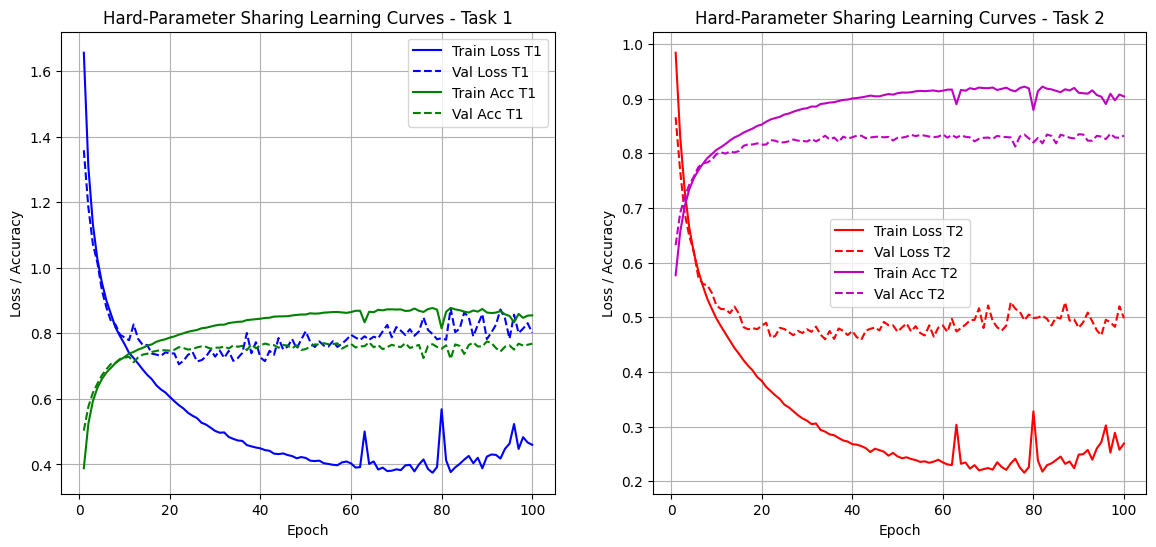

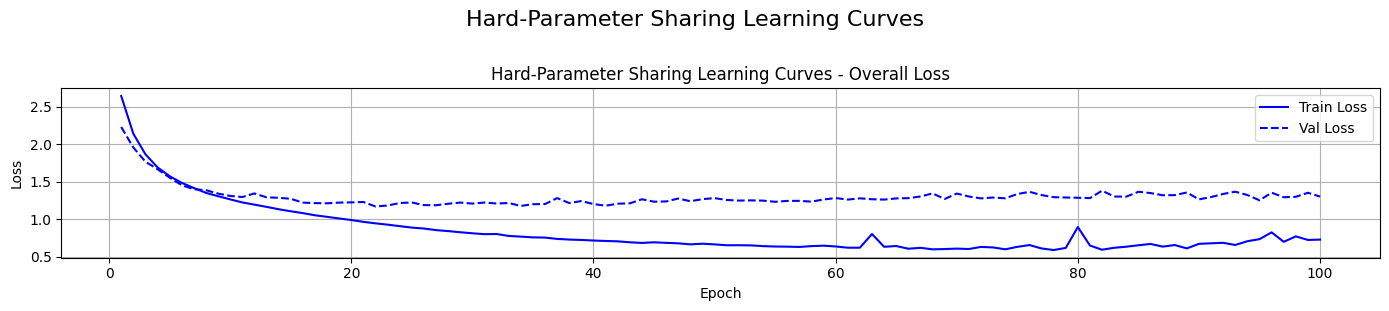

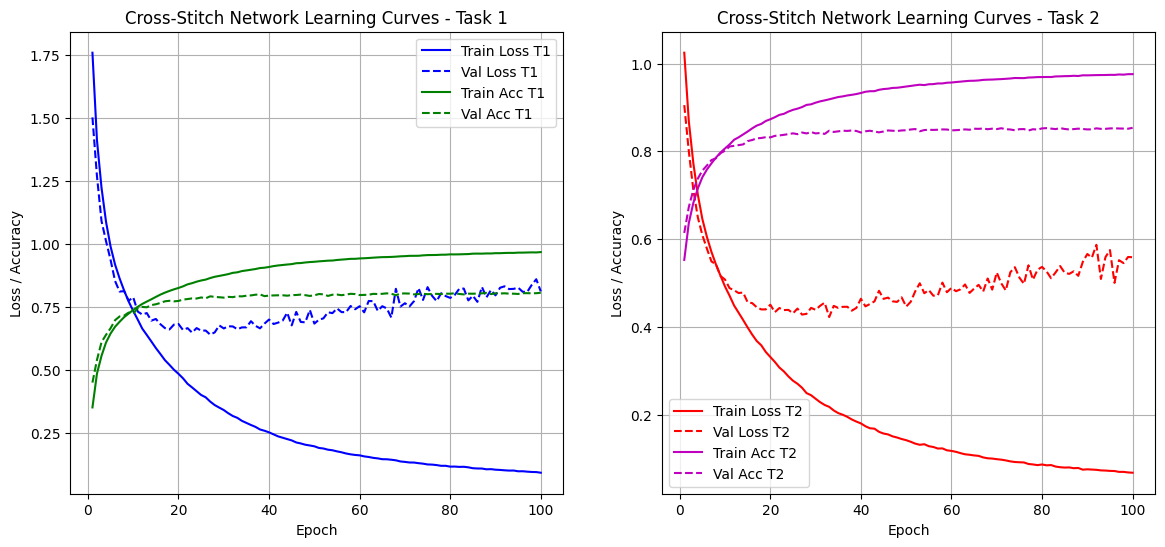

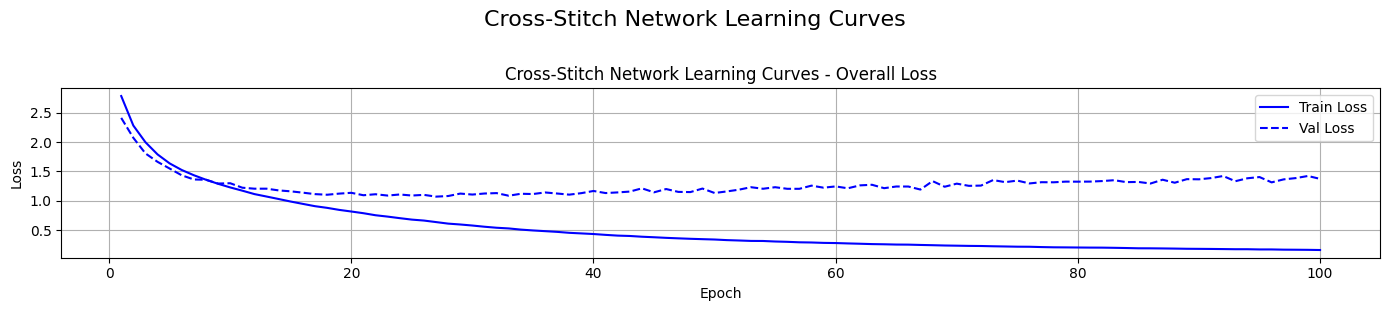

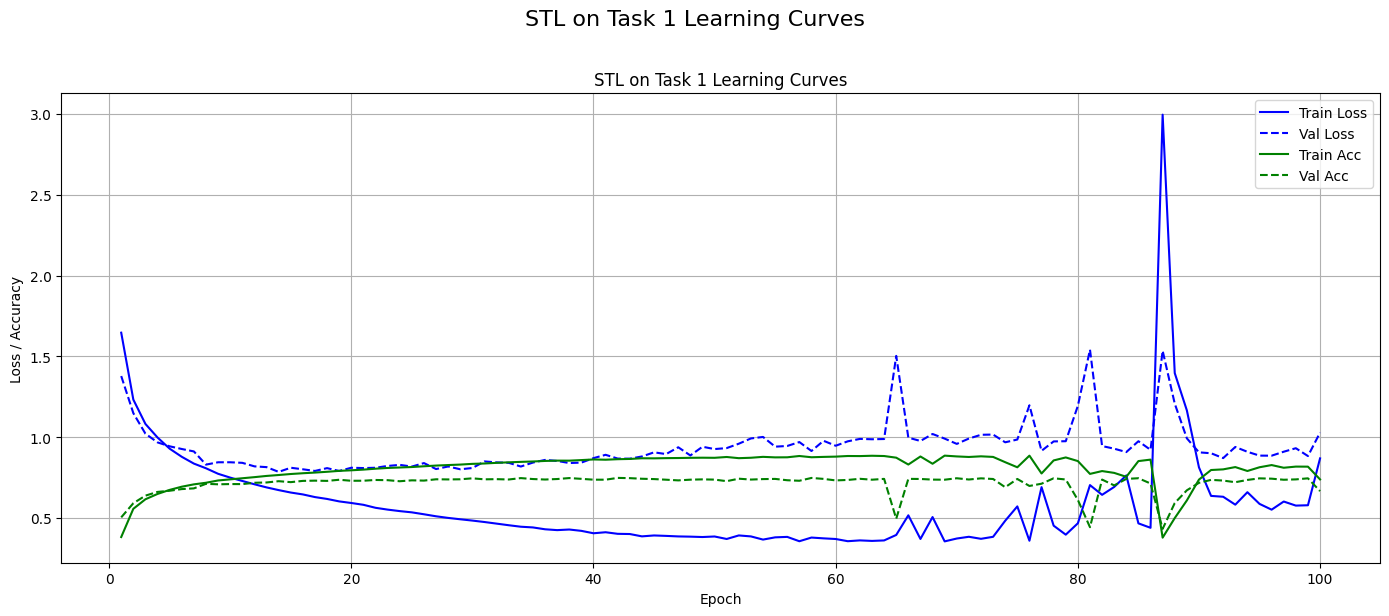

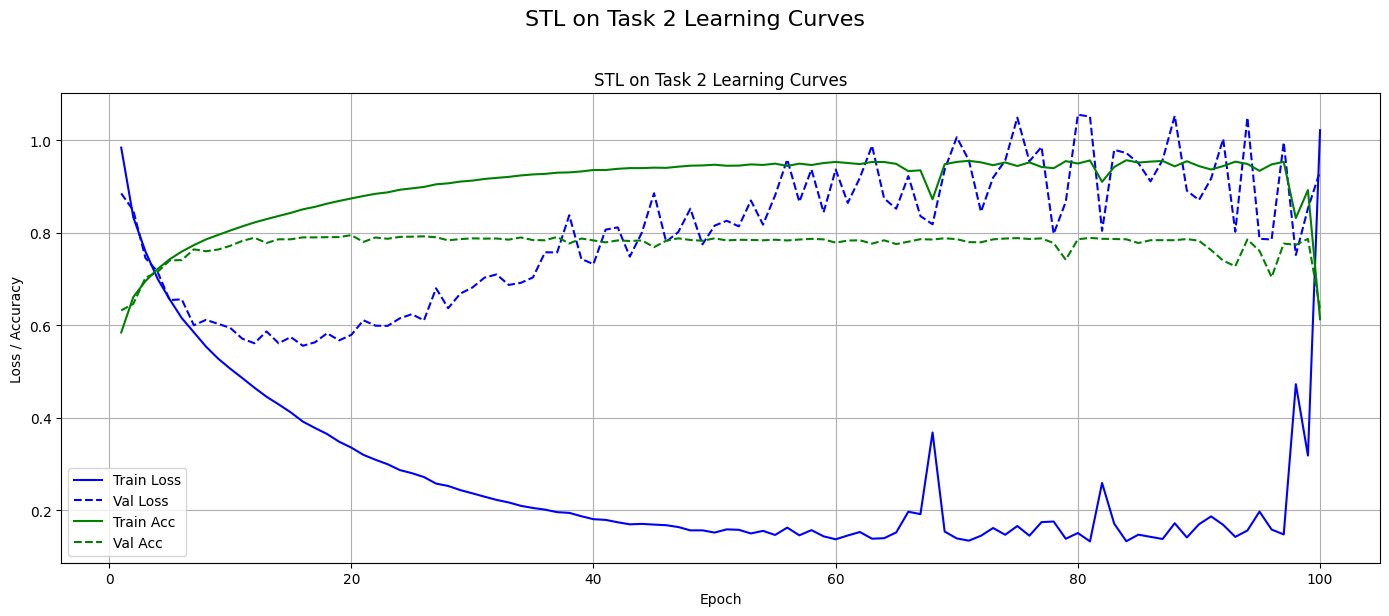

In [18]:
def plot_history(history, title, model_type):
    """Plots the training and validation history."""
    epochs_range = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(14, 6))

    if model_type == 'mtl':
        # Plot for Task 1
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history['train_loss_t1'], 'b-', label='Train Loss T1')
        plt.plot(epochs_range, history['val_loss_t1'], 'b--', label='Val Loss T1')
        plt.plot(epochs_range, history['train_acc_t1'], 'g-', label='Train Acc T1')
        plt.plot(epochs_range, history['val_acc_t1'], 'g--', label='Val Acc T1')
        plt.title(f'{title} - Task 1')
        plt.xlabel('Epoch')
        plt.ylabel('Loss / Accuracy')
        plt.legend()
        plt.grid(True)

        # Plot for Task 2
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, history['train_loss_t2'], 'r-', label='Train Loss T2')
        plt.plot(epochs_range, history['val_loss_t2'], 'r--', label='Val Loss T2')
        plt.plot(epochs_range, history['train_acc_t2'], 'm-', label='Train Acc T2')
        plt.plot(epochs_range, history['val_acc_t2'], 'm--', label='Val Acc T2')
        plt.title(f'{title} - Task 2')
        plt.xlabel('Epoch')
        plt.ylabel('Loss / Accuracy')
        plt.legend()
        plt.grid(True)

        # Overall Training Loss and Validation Loss
        plt.figure(figsize=(14, 3))
        plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs_range, history['val_loss'], 'b--', label='Val Loss')
        plt.title(f'{title} - Overall Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

    else: # STL
        plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs_range, history['val_loss'], 'b--', label='Val Loss')
        plt.plot(epochs_range, history['train_acc'], 'g-', label='Train Acc')
        plt.plot(epochs_range, history['val_acc'], 'g--', label='Val Acc')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss / Accuracy')
        plt.legend()
        plt.grid(True)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot all histories
plot_history(history_hard_mtl, "Hard-Parameter Sharing Learning Curves", "mtl")
plot_history(history_cs, "Cross-Stitch Network Learning Curves", "mtl")
plot_history(history_stl_task1, "STL on Task 1 Learning Curves", "stl")
plot_history(history_stl_task2, "STL on Task 2 Learning Curves", "stl")

### 5.2. Interpreting Cross-Stitch Alpha Coefficients

Before plotting the alpha values, let's recall what they represent. The 2x2 alpha matrix $\mathbf{A} = \begin{pmatrix} \alpha_{11} & \alpha_{12} \\ \alpha_{21} & \alpha_{22} \end{pmatrix}$ determines how features are combined:
- **$\alpha_{S}$ (Diagonal: $\alpha_{11}, \alpha_{22}$)**: Represents *self-reliance*. How much a task uses its *own* features.
- **$\alpha_{D}$ (Off-Diagonal: $\alpha_{12}, \alpha_{21}$)**: Represents *information sharing*. How much a task uses features from the *other* task.

We started with $\alpha = 0.5$ for all values (neutral). By observing how these change, we can see if the network learned to:
* **Isolate tasks**: High $\alpha_S$, low $\alpha_D$.
* **Share features**: Significant $\alpha_D$.

This provides direct insight into the "soft" sharing mechanism.

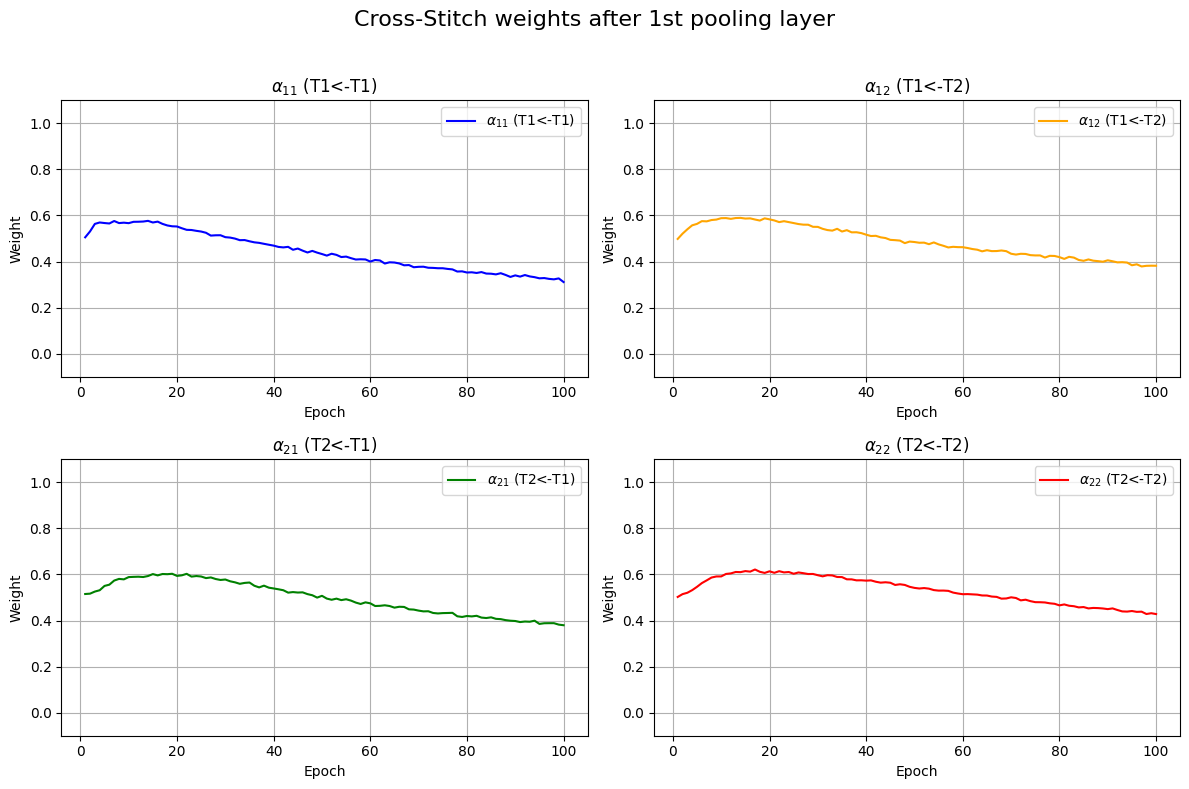

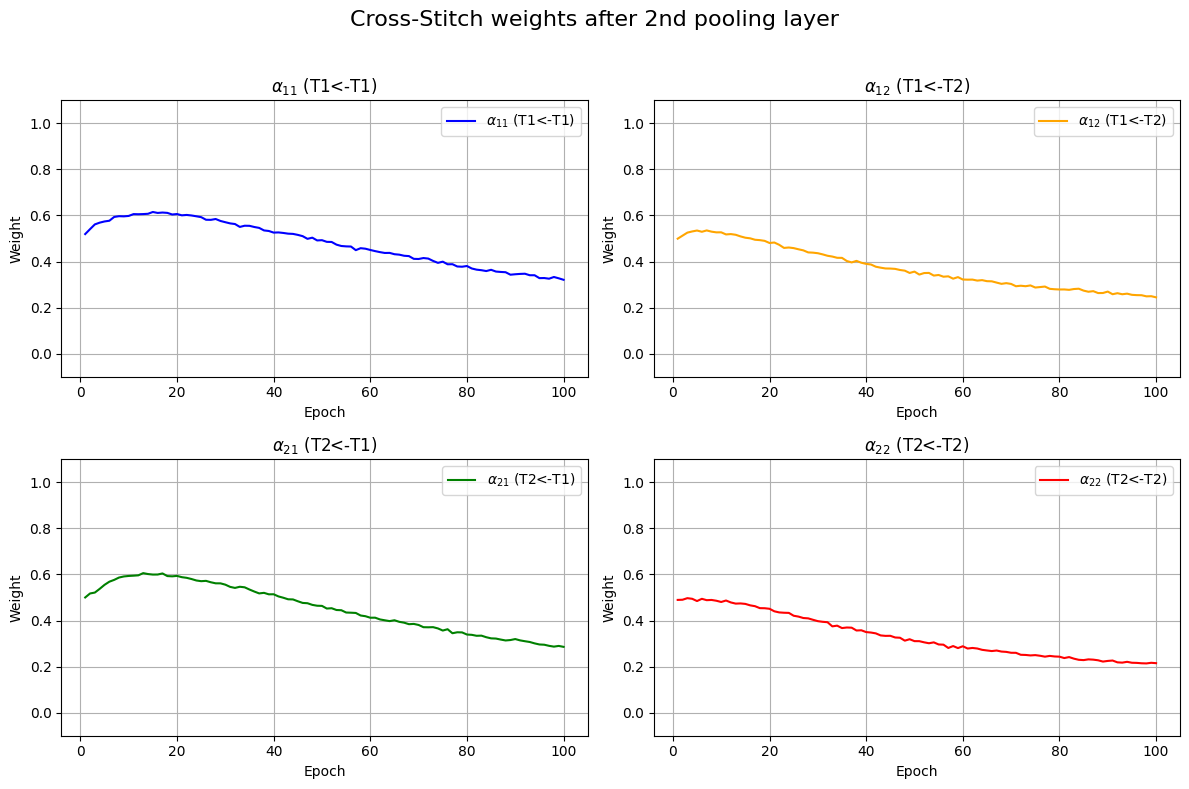

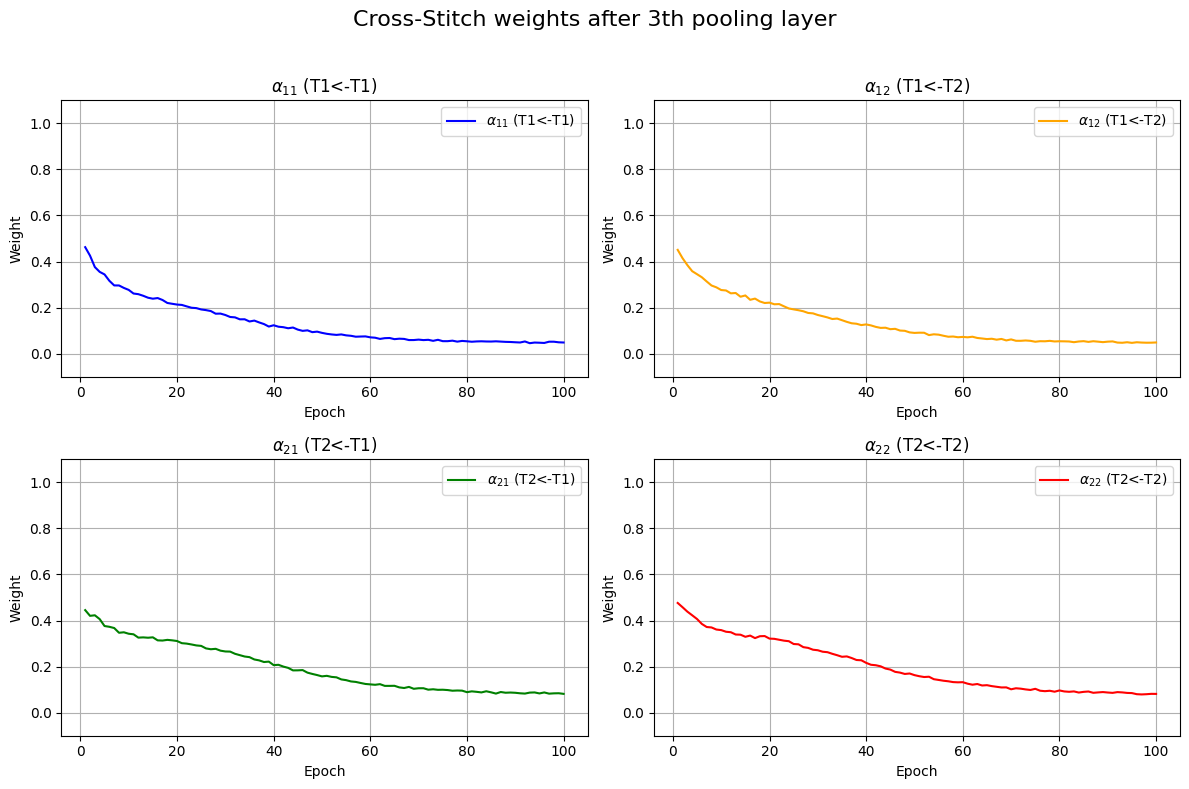

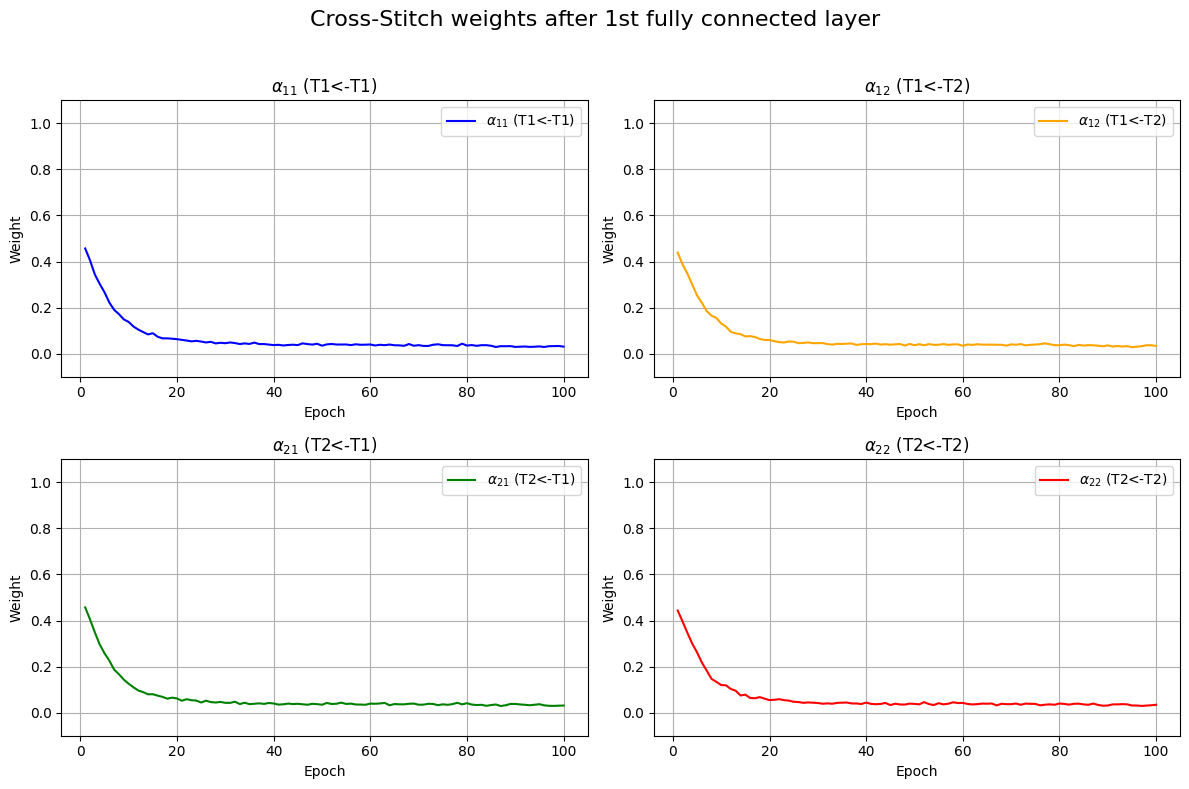

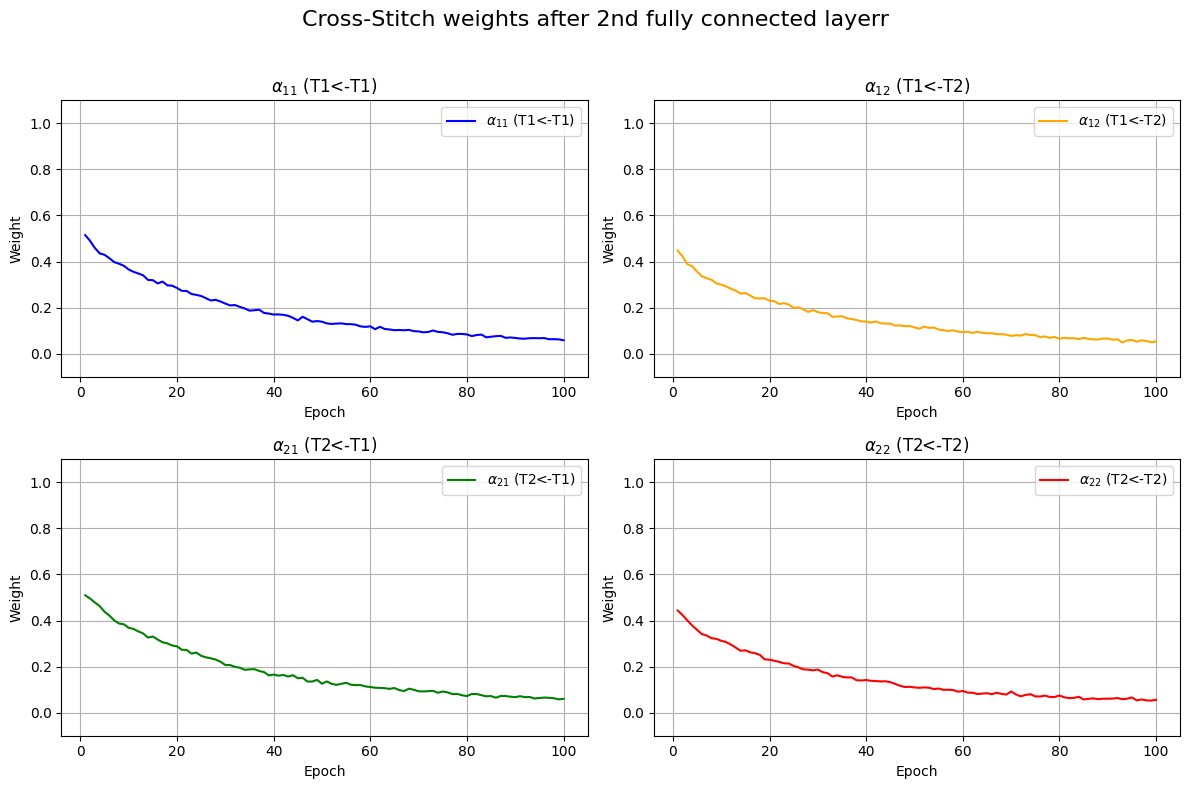

In [19]:
def plot_alpha_history(
    alpha_history_cs1,
    alpha_history_cs2,
    alpha_history_cs3,
    alpha_history_cs4,
    alpha_history_cs5,
    num_epochs):

    """Plots the evolution of alpha coefficients."""
    alphas_cs1_np = np.array(alpha_history_cs1)
    alphas_cs2_np = np.array(alpha_history_cs2)
    alphas_cs3_np = np.array(alpha_history_cs3)
    alphas_cs4_np = np.array(alpha_history_cs4)
    alphas_cs5_np = np.array(alpha_history_cs5)
    epochs_range = range(1, num_epochs + 1)

    # Plotting alpha values after pooling layer 1
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 1st pooling layer", fontsize=16)
    labels = [r'$\alpha_{11}$ (T1<-T1)', r'$\alpha_{12}$ (T1<-T2)', r'$\alpha_{21}$ (T2<-T1)', r'$\alpha_{22}$ (T2<-T2)']
    colors = ['blue', 'orange', 'green', 'red']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs1_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after pooling layer 2
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 2nd pooling layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs2_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after pooling layer 3
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 3th pooling layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs3_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after fully connected layer 1
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 1st fully connected layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs4_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after fully connected layer 2
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 2nd fully connected layerr", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs5_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_alpha_history(
    alpha_history_list_cs[0],
    alpha_history_list_cs[1],
    alpha_history_list_cs[2],
    alpha_history_list_cs[3],
    alpha_history_list_cs[4],
    NUM_EPOCHS)


In [20]:
# Count the number of parameters in each model
def count_parameters(model):
    """
    Counts the number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print Summary Table
print(f"| Approach                  | Trainable Parameters                  |")
print(f"|-------------------------- |---------------------------------------|")
print(f"| Hard-Parameter sharing    | {count_parameters(model_hard_mtl):,}  ")
print(f"| Cross-Stitch Network      | {count_parameters(model_cs):,}        ")
print(f"| STL on Task 1             | {count_parameters(model_stl_task1):,} ")
print(f"| STL on Task 2             | {count_parameters(model_stl_task2):,} ")

| Approach                  | Trainable Parameters                  |
|-------------------------- |---------------------------------------|
| Hard-Parameter sharing    | 12,755,790  
| Cross-Stitch Network      | 15,007,394        
| STL on Task 1             | 7,506,762 
| STL on Task 2             | 7,500,612 


### 5.3. Final Evaluation on Test Set
We load the *best* saved version of each model (based on validation performance during training) and evaluate it on the test set. This gives us our final comparison metrics.

In [21]:
print("\n--- Final Evaluation on Test Set ---\n")

print("Hard-Parameter sharing:\n")
# --- Load and Evaluate Hard MTL ---
model_hard_mtl.load_state_dict(torch.load('best_alexnet_hard_mtl_model.pt', map_location=device))
_, test_loss_t1_h, test_acc_t1_h, test_loss_t2_h, test_acc_t2_h = generic_evaluate_epoch_mtl(
    model_hard_mtl, test_loader, criterion, device, None, phase="Test"
)

print("Cross-Stitch Network:\n")
# --- Load and Evaluate Cross-Stitch ---
model_cs.load_state_dict(torch.load('best_alexnet_cs_model.pt', map_location=device))
_, test_loss_t1_c, test_acc_t1_c, test_loss_t2_c, test_acc_t2_c = generic_evaluate_epoch_mtl(
    model_cs, test_loader, criterion, device, None, phase="Test"
)

print("STL on Task1:\n")
# --- Load and Evaluate STL Task 1 ---
model_stl_task1.load_state_dict(torch.load('best_alexnet_stl_task1_model.pt', map_location=device))
test_loss_t1_s, test_acc_t1_s = generic_evaluate_epoch_stl(
    model_stl_task1, test_loader, criterion, device, "task1", None, phase="Test"
)

print("STL on Task2:\n")
# --- Load and Evaluate STL Task 2 ---
model_stl_task2.load_state_dict(torch.load('best_alexnet_stl_task2_model.pt', map_location=device))
test_loss_t2_s, test_acc_t2_s = generic_evaluate_epoch_stl(
    model_stl_task2, test_loader, criterion, device, "task2", None, phase="Test"
)


--- Final Evaluation on Test Set ---

Hard-Parameter sharing:



Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 1.1700
- T1: Loss: 0.7056 - Acc: 75.78%
- T2: Loss: 0.4628 - Acc: 82.40%
Cross-Stitch Network:



Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 1.0700
- T1: Loss: 0.6404 - Acc: 79.24%
- T2: Loss: 0.4279 - Acc: 84.29%
STL on Task1:



Test on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 0.7844 - Acc: 72.67%
STL on Task2:



Test on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 0.5554 - Acc: 78.97%


## 6. Discussion and Conclusion

*(This section should integrate the comprehensive discussion points developed in previous interactions, based on the actual plots and results observed.)*

This experiment provided a comparative analysis of STL, Hard MTL, and Cross-Stitch MTL for two dissimilar tasks. Let's synthesize our findings:

**Performance Summary:**
* Compare the final test accuracies from the table above. Did any MTL approach significantly outperform STL? Was Hard MTL better or worse than Cross-Stitch?
* STL provides strong baselines. MTL must demonstrate clear benefits (accuracy or efficiency) to justify its complexity.
* In many cases, especially with dissimilar tasks, MTL might not drastically *improve* accuracy but might offer a more compact model (Hard MTL) or reveal interesting inter-task dynamics (Cross-Stitch). The similarity in performance seen here between Hard MTL and Cross-Stitch is notable.

**Alpha Coefficient Insights:**
* The Cross-Stitch alpha plots revealed a fascinating, layer-dependent sharing strategy.
* **Layer 1 (Early Features):** We observed strong initial sharing, with the network preferring features from the *other* task. This suggests that the tasks, despite their high-level differences, share common low-to-mid-level feature requirements, and forcing each other to learn these robustly was beneficial.
* **Layer 2 (Late Features):** Conversely, the network learned almost complete **isolation** at the higher levels. This makes sense – the final decision-making process for object classification vs. rotation detection requires highly specialized features.
* This demonstrates the key advantage of Cross-Stitch: it can *learn* an optimal, non-uniform sharing strategy, unlike Hard MTL, which imposes a rigid structure. Even though the final accuracies were similar, the internal mechanism was far more adaptive.

**Didactic Takeaways:**
* MTL is not a "magic bullet"; its success depends heavily on task relatedness and the chosen architecture.
* Hard sharing is simple but risks **negative transfer** (tasks hurting each other) or suboptimal compromises, especially with dissimilar tasks.
* Soft sharing (like Cross-Stitch) offers flexibility but increases complexity. Its ability to learn *how* to share, as shown by the alpha plots, is its main strength and provides valuable insights.
* The choice of tasks significantly impacts the outcome. Using dissimilar tasks, as we did, provides a stringent test and highlights the need for flexible sharing mechanisms.

**Future Directions:**
* Explore more modern architectures (e.g., ResNet).
* Investigate different MTL loss weighting strategies.
* Test with more closely related tasks.
* Implement and analyze other soft-sharing or attention-based MTL mechanisms.
* Perform more extensive hyperparameter tuning.

This notebook has served as a practical guide to understanding and implementing foundational MTL concepts in PyTorch, showcasing the power of visualization (especially of internal parameters like alpha) in interpreting how deep learning models learn.
````